<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2 Regression Challenge

_Authors: Joel Quek (SG)_

# Problem Statement

What are factors affecting housing price?

**Create a model** for housing price prediction based on multiple key factors.

Also, distill the key factors affecting housing price.

# Table of Contents

# Import Libraries 

In [2739]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso,RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm  

from IPython.display import display #display allows display of all columns with headers

%matplotlib inline

# Cleaned Data Sets and [Column Documentation](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

The data has been cleaned in another file titled 'project_2_data_clean.ipynb'

I grouped the data according to different classes of factors affecting house value
1. Location and Proximity to Amenities
2. Quality and Condition of the Home
3. Parts of the Home
4. Dimensions
5. Utilities and Intangible Factors
6. Time Factors
7. Price Factors

Documentation of the column headers can be found at the [Journal of Statistics Education](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

In [2740]:
location_proximity_df=pd.read_csv('location_proximity.csv')
quality_condition_df=pd.read_csv('quality_condition.csv')
parts_of_home_df=pd.read_csv('parts_of_home.csv')
dimensions_df=pd.read_csv('dimensions.csv')
utilities_intangible_df=pd.read_csv('utilities_intangible.csv')
time_factors_df=pd.read_csv('time_factors.csv')
price_factors_df=pd.read_csv('price_factors.csv')

# Factor 1: Location and Proximity 

In [2741]:
location_proximity_df.drop('Unnamed: 0', axis=1, inplace=True)
price_factors_df.drop(['Unnamed: 0'], axis=1, inplace=True)
location_proximity_price_df = location_proximity_df.join(price_factors_df, how='outer')
print(location_proximity_price_df.shape)
location_proximity_price_df.head(3)

(1887, 14)


,MS SubClass,MS Zoning,Lot Config,Neighborhood,Condition 1,Condition 2,Bldg Type,Land Contour,Land Slope,Street,Lot Shape,Sale Type,SalePrice,Price Per Sq Ft
0,2 Storey 1946 Newer,Residential Low Density,CulDSac,Sawyer,RRAe,Norm,1Fam,Lvl,Gtl,Pave,IR1,WD,130500,9.654509
1,2 Storey 1946 Newer,Residential Low Density,CulDSac,SawyerW,Norm,Norm,1Fam,Lvl,Gtl,Pave,IR1,WD,220000,19.143752
2,1 Storey Newer All,Residential Low Density,Inside,NAmes,Norm,Norm,1Fam,Lvl,Gtl,Pave,Reg,WD,109000,13.759152


In [2742]:
location_proximity_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1887 entries, 0 to 1886
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MS SubClass      1887 non-null   object 
 1   MS Zoning        1887 non-null   object 
 2   Lot Config       1887 non-null   object 
 3   Neighborhood     1887 non-null   object 
 4   Condition 1      1887 non-null   object 
 5   Condition 2      1887 non-null   object 
 6   Bldg Type        1887 non-null   object 
 7   Land Contour     1887 non-null   object 
 8   Land Slope       1887 non-null   object 
 9   Street           1887 non-null   object 
 10  Lot Shape        1887 non-null   object 
 11  Sale Type        1887 non-null   object 
 12  SalePrice        1887 non-null   int64  
 13  Price Per Sq Ft  1887 non-null   float64
dtypes: float64(1), int64(1), object(12)
memory usage: 206.5+ KB


Given that most of the datatypes are objects, I will use K-NN or hot-encode the object data to model

---

## Data Dictionary for Location and Proximity Factors

|Feature|Type|Dataset|Description|Details|
|---|---|---|---|---| 
|MS SubClass	|||Identifies the type of dwelling involved in the sale. <br> For example how many storeys are present and how old the properties are.||
|MS Zoning	|||Identifies the general zoning classification of the sale. <br> For example commercial, residential, industrial zone etc  ||
|Lot Config|||Lot configuration <br> Eg. inside lot, corner lot, cul-de-sac, frontage etc||
|Neighborhood|||Physical locations within Ames city limits (map available) <br>||
|Condition 1	|||Proximity to various conditions <br> Eg. adjacent to arterial street, adjacent to feeder street, within 200 feet of NS Railroad etc||
|Condition 2|||Proximity to various conditions (if more than one is present) <br> Eg. adjacent to arterial street, adjacent to feeder street, within 200 feet of NS Railroad etc||
|Bldg Type|||Type of dwelling <br> Eg. Single-family detached, two-family conversion, duplex, townhouse etc||
|Land Contour|||Flatness of the property <br> Eg. level, banked, hillside, depression||
|Land Slope|||Slope of property <br> Eg. Gtl	Gentle slope<br>   Mod	Moderate Slope	<br>  Sev	Severe Slope||
|Street|||Type of road access to property <br>      Grvl	Gravel	<br>  Pave	Paved||
|Lot Shape|||General shape of property <br> Reg	Regular	<br>IR1	Slightly irregular<br>IR2	Moderately Irregular<br>IR3	Irregular||
|Sale Type|||Type of sale <br>||
|SalePrice|||Sale price $$ <br>||

## Hot Encode Categorical Data [via get_dummies]

In [2743]:
location_proximity_price_df.columns

Index(['MS SubClass', 'MS Zoning', 'Lot Config', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'Land Contour', 'Land Slope', 'Street',
       'Lot Shape', 'Sale Type', 'SalePrice', 'Price Per Sq Ft'],
      dtype='object')

In [2744]:
location_proximity_price_dummies_df = pd.get_dummies(location_proximity_price_df,columns=['MS SubClass', 'MS Zoning', 'Lot Config', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'Land Contour', 'Land Slope', 'Street',
       'Lot Shape', 'Sale Type'], drop_first=True)

print(location_proximity_price_dummies_df.shape)
location_proximity_price_dummies_df.head(3)


(1887, 88)


,SalePrice,Price Per Sq Ft,MS SubClass_1 Storey Newer All,MS SubClass_1 Storey PUD,MS SubClass_1 Storey W/Finished Attic,MS SubClass_1.5 Finished,MS SubClass_1.5 Storey PUD,MS SubClass_1.5 Unfinished,MS SubClass_2 Storey 1946 Newer,MS SubClass_2 Storey 1946 Older,...,Lot Shape_IR3,Lot Shape_Reg,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
0,130500,9.654509,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,220000,19.143752,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,109000,13.759152,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


## Correlation of Various Location and Proximity Factors

In [2745]:
location_proximity_price_dummies_df.corr()

,SalePrice,Price Per Sq Ft,MS SubClass_1 Storey Newer All,MS SubClass_1 Storey PUD,MS SubClass_1 Storey W/Finished Attic,MS SubClass_1.5 Finished,MS SubClass_1.5 Storey PUD,MS SubClass_1.5 Unfinished,MS SubClass_2 Storey 1946 Newer,MS SubClass_2 Storey 1946 Older,...,Lot Shape_IR3,Lot Shape_Reg,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
SalePrice,1.000000,0.271195,0.055966,0.083473,-0.040061,-0.191496,-0.011458,-0.060633,0.337426,-0.088395,...,0.004906,-0.290316,-0.000893,0.031715,-0.032787,0.025732,-0.041220,0.357685,-0.034243,-0.216067
Price Per Sq Ft,0.271195,1.000000,-0.249424,0.455424,-0.018491,-0.128728,0.115060,-0.018720,-0.000270,-0.042571,...,-0.048025,0.069209,-0.006848,-0.003297,0.006617,0.001816,-0.034370,0.164444,-0.025135,-0.092099
MS SubClass_1 Storey Newer All,0.055966,-0.249424,1.000000,-0.216712,-0.036569,-0.257649,-0.018270,-0.054927,-0.405632,-0.169113,...,-0.039129,-0.046402,0.002050,0.010760,-0.012941,-0.025479,-0.040896,0.072300,0.022975,-0.095670
MS SubClass_1 Storey PUD,0.083473,0.455424,-0.216712,1.000000,-0.012589,-0.088694,-0.006289,-0.018908,-0.139636,-0.058216,...,0.011354,-0.070503,0.008781,0.032745,-0.019936,-0.015426,-0.014078,0.061154,-0.010899,-0.031831
MS SubClass_1 Storey W/Finished Attic,-0.040061,-0.018491,-0.036569,-0.012589,1.000000,-0.014967,-0.001061,-0.003191,-0.023563,-0.009824,...,-0.003191,0.036528,-0.003364,-0.002124,-0.003364,-0.002603,-0.002376,-0.013885,-0.001839,0.018260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sale Type_ConLI,0.025732,0.001816,-0.025479,-0.015426,-0.002603,0.045748,-0.001301,-0.003910,0.017575,-0.012038,...,-0.003910,-0.013250,-0.004122,-0.002603,-0.004122,1.000000,-0.002911,-0.017014,-0.002254,-0.142557
Sale Type_ConLw,-0.041220,-0.034370,-0.040896,-0.014078,-0.002376,0.053449,-0.001187,-0.003568,-0.000917,-0.010986,...,-0.003568,-0.001504,-0.003762,-0.002376,-0.003762,-0.002911,1.000000,-0.015528,-0.002057,-0.130101
Sale Type_New,0.357685,0.164444,0.072300,0.061154,-0.013885,-0.097824,-0.006937,-0.020855,0.111104,-0.064209,...,0.006996,-0.056879,-0.021988,-0.013885,-0.021988,-0.017014,-0.015528,1.000000,-0.012021,-0.760385
Sale Type_Oth,-0.034243,-0.025135,0.022975,-0.010899,-0.001839,-0.012958,-0.000919,-0.002762,-0.020401,-0.008505,...,-0.002762,0.004301,-0.002913,-0.001839,-0.002913,-0.002254,-0.002057,-0.012021,1.000000,-0.100723


## Linear Regression on Location and Proximity Factors

### Step 1: Assemble our predictor variables (X) and our target (y) 

I will perform linear regression on Location and PRoximity Factors against the Price per Square Feet

In [2746]:
X = location_proximity_price_dummies_df.drop(columns = ["SalePrice", "Price Per Sq Ft"])
y = location_proximity_price_dummies_df["Price Per Sq Ft"]

Note that X has been "dummified" earlier

In [2747]:
X.head()

,MS SubClass_1 Storey Newer All,MS SubClass_1 Storey PUD,MS SubClass_1 Storey W/Finished Attic,MS SubClass_1.5 Finished,MS SubClass_1.5 Storey PUD,MS SubClass_1.5 Unfinished,MS SubClass_2 Storey 1946 Newer,MS SubClass_2 Storey 1946 Older,MS SubClass_2 Storey PUD,MS SubClass_2.5 Story All,...,Lot Shape_IR3,Lot Shape_Reg,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [2748]:
y

0        9.654509
1       19.143752
2       13.759152
3       17.751479
4        9.729540
          ...    
1882    26.094069
1883     6.684492
1884    23.418894
1885    13.846154
1886    25.200000
Name: Price Per Sq Ft, Length: 1887, dtype: float64

### Step 2: Instantiate the model

In [2749]:
model = LinearRegression()

### Step 3: Fit the model

In [2750]:
model.fit(X,y)

LinearRegression()

### Step 4: Coefficients 

In [2751]:
X.columns

Index(['MS SubClass_1 Storey Newer All', 'MS SubClass_1 Storey PUD',
       'MS SubClass_1 Storey W/Finished Attic', 'MS SubClass_1.5 Finished',
       'MS SubClass_1.5 Storey PUD', 'MS SubClass_1.5 Unfinished',
       'MS SubClass_2 Storey 1946 Newer', 'MS SubClass_2 Storey 1946 Older',
       'MS SubClass_2 Storey PUD', 'MS SubClass_2.5 Story All',
       'MS SubClass_Duplex All', 'MS SubClass_Family Conversion',
       'MS SubClass_PUD Multi', 'MS SubClass_Split', 'MS SubClass_Split Foyer',
       'MS Zoning_Floating Village Residential',
       'MS Zoning_Residential High Density',
       'MS Zoning_Residential Low Density',
       'MS Zoning_Residential Medium Density', 'Lot Config_CulDSac',
       'Lot Config_FR2', 'Lot Config_FR3', 'Lot Config_Inside',
       'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_Gree

In [2752]:
model.coef_

array([ 4.11618086e+00,  1.62973232e+01,  3.25553833e+00,  2.66879219e+00,
        5.50351898e+01,  3.03495414e+00,  6.01193497e+00,  4.37327230e+00,
        2.57131627e+01,  2.64254374e+00, -6.26309425e+13,  3.13935452e+00,
        2.55016661e+01,  4.33905786e+00,  4.99312239e+00,  6.04121335e+00,
        3.01767088e+00,  1.03826118e+00,  5.47451437e+00, -1.75361446e-01,
       -1.59196061e+00, -3.68689550e+00,  1.13320646e+00, -1.11826056e+01,
       -2.61224918e+01, -2.61593061e+01, -2.80119968e+01, -2.53514244e+01,
       -2.47955941e+01, -3.11082915e+01, -2.70567493e+01, -1.97398178e+01,
       -3.08516612e+01, -3.09970703e+01, -4.59145508e+01, -3.16380615e+01,
       -2.90058594e+01, -2.98085938e+01, -1.52714844e+01, -2.83585205e+01,
       -1.91054688e+01, -2.05664062e+01, -3.00507812e+01, -2.35957031e+01,
       -2.99609375e+01, -2.71499023e+01, -2.14121094e+01, -2.17832031e+01,
       -2.47441406e+01, -2.88712769e+01, -1.85546875e-02,  3.67187500e-01,
       -8.33740234e-01,  

In [2753]:
coef_dict = dict(zip(X.columns, model.coef_))
coef_dict

{'MS SubClass_1 Storey Newer All': 4.116180861404746,
 'MS SubClass_1 Storey PUD': 16.297323212071863,
 'MS SubClass_1 Storey W/Finished Attic': 3.2555383329103478,
 'MS SubClass_1.5 Finished': 2.668792185138585,
 'MS SubClass_1.5 Storey PUD': 55.0351898488621,
 'MS SubClass_1.5 Unfinished': 3.0349541371168685,
 'MS SubClass_2 Storey 1946 Newer': 6.011934972189831,
 'MS SubClass_2 Storey 1946 Older': 4.373272296288965,
 'MS SubClass_2 Storey PUD': 25.713162655285526,
 'MS SubClass_2.5 Story All': 2.6425437418483053,
 'MS SubClass_Duplex All': -62630942528828.21,
 'MS SubClass_Family Conversion': 3.139354517040153,
 'MS SubClass_PUD Multi': 25.501666059415136,
 'MS SubClass_Split': 4.339057864066492,
 'MS SubClass_Split Foyer': 4.993122387314648,
 'MS Zoning_Floating Village Residential': 6.041213354896681,
 'MS Zoning_Residential High Density': 3.01767088349081,
 'MS Zoning_Residential Low Density': 1.038261178995528,
 'MS Zoning_Residential Medium Density': 5.474514369206437,
 'Lot Co

Sort Coefficient Dictionary based on Coefficient Strength

In [2754]:
{k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}

# source https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value

{'MS SubClass_Duplex All': -62630942528828.21,
 'Neighborhood_Landmrk': -45.91455078125,
 'Neighborhood_MeadowV': -31.6380615234375,
 'Neighborhood_Edwards': -31.108291518347446,
 'Neighborhood_IDOTRR': -30.9970703125,
 'Neighborhood_GrnHill': -30.851661237697552,
 'Neighborhood_OldTown': -30.05078125,
 'Neighborhood_Sawyer': -29.9609375,
 'Neighborhood_NAmes': -29.80859375,
 'Neighborhood_Mitchel': -29.005859375,
 'Neighborhood_Veenker': -28.87127685546875,
 'Neighborhood_NWAmes': -28.3585205078125,
 'Neighborhood_ClearCr': -28.011996803911224,
 'Neighborhood_SawyerW': -27.14990234375,
 'Neighborhood_Gilbert': -27.056749291113285,
 'Neighborhood_BrkSide': -26.1593060641109,
 'Neighborhood_BrDale': -26.1224917883007,
 'Neighborhood_CollgCr': -25.351424439218345,
 'Neighborhood_Crawfor': -24.795594076207543,
 'Neighborhood_Timber': -24.744140625,
 'Neighborhood_SWISU': -23.595703125,
 'Neighborhood_StoneBr': -21.783203125,
 'Neighborhood_Somerst': -21.412109375,
 'Neighborhood_NridgHt':

In [2755]:
{k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1], reverse=True)}


{'Bldg Type_Duplex': 62630942528833.164,
 'MS SubClass_1.5 Storey PUD': 55.0351898488621,
 'MS SubClass_2 Storey PUD': 25.713162655285526,
 'MS SubClass_PUD Multi': 25.501666059415136,
 'MS SubClass_1 Storey PUD': 16.297323212071863,
 'Bldg Type_Twnhs': 15.2406005859375,
 'Condition 2_PosA': 9.0482177734375,
 'Condition 2_PosN': 6.07373046875,
 'MS Zoning_Floating Village Residential': 6.041213354896681,
 'MS SubClass_2 Storey 1946 Newer': 6.011934972189831,
 'MS Zoning_Residential Medium Density': 5.474514369206437,
 'Land Contour_HLS': 5.20703125,
 'Street_Pave': 5.005126953125,
 'MS SubClass_Split Foyer': 4.993122387314648,
 'Sale Type_ConLI': 4.533111572265625,
 'MS SubClass_2 Storey 1946 Older': 4.373272296288965,
 'MS SubClass_Split': 4.339057864066492,
 'MS SubClass_1 Storey Newer All': 4.116180861404746,
 'Sale Type_New': 3.390625,
 'MS SubClass_1 Storey W/Finished Attic': 3.2555383329103478,
 'Condition 2_Norm': 3.17236328125,
 'MS SubClass_Family Conversion': 3.13935451704015

There are 86 coefficients due to dummification

#### Interpretation of Coefficients

Reminder to self: Refer to lecture 3.01 Linear Regression

- The effect of a home being MS SubClass_1 Storey Newer All contributes to the price per square feet increasing by 10.041132589968962

- The effect of a home being MS Zoning_Floating Village Residential contributes to the price per square feet increasing by 8.498955709179087

Here are other effects on Price per Square Feet

- 'MS SubClass_Split Foyer': 7.9002345473575515,
- 'MS SubClass_1.5 Finished': 6.026154574733448,
- 'MS SubClass_Split': 2.3465197376865445,
- 'Lot Config_CulDSac': 2.257515725266754,
- 'MS SubClass_2 Storey 1946 Older': 1.2833856211755341,
- 'MS SubClass_1.5 Unfinished': 1.0296480826226686,

### Step 5: Make Predictions

In [2756]:
X.head(3)

,MS SubClass_1 Storey Newer All,MS SubClass_1 Storey PUD,MS SubClass_1 Storey W/Finished Attic,MS SubClass_1.5 Finished,MS SubClass_1.5 Storey PUD,MS SubClass_1.5 Unfinished,MS SubClass_2 Storey 1946 Newer,MS SubClass_2 Storey 1946 Older,MS SubClass_2 Storey PUD,MS SubClass_2.5 Story All,...,Lot Shape_IR3,Lot Shape_Reg,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [2757]:
y_preds = model.predict(X)
y_preds # y_preds are points on the regression plane 
# y_preds are the predicted price per square feet

array([12.24826704, 18.51535688, 15.72065115, ..., 17.70178949,
       14.58744469, 20.36824972])

### Step 6: Evaluate the model

$R^2$

In [2758]:
# R2:
metrics.r2_score(y, y_preds)

0.7898940574012766

78.9% of the data fall on the regression plane. Not bad!

MSE

In [2759]:
# MSE:
metrics.mean_squared_error(y, y_preds) 

35.72971780623902

How is our model?

---

# [KIV Section] for Factor 1

## Simplify Model and Focus on a Few Specific Factors

Looking at the correlation data above, it is extremely confusing. I will split my dataset down into bite-sized parts to study them.

Reading an [article on Investopedia](https://www.investopedia.com/articles/mortgages-real-estate/08/housing-appreciation.asp), I quote 

"Many first-time home buyers believe the **physical characteristics** of a house will lead to increased property value. But in reality, a property's physical structure tends to depreciate over time, while the **land it sits on** typically appreciates in value."

Therefore, I will focus my study on **MS Zoning, Condition 1 and Condition 2**.

## Sub-Factor 1A: Zone and Neighbourhood Factors

In [2760]:
zone_condition_df = location_proximity_price_df[['MS Zoning', 'Condition 1', 'Condition 2','Neighborhood', 'Price Per Sq Ft']]
zone_condition_df = pd.get_dummies(zone_condition_df,columns=['MS Zoning', 'Condition 1', 'Condition 2', 'Neighborhood'], drop_first=True)

In [2761]:
zone_condition_df.head()

,Price Per Sq Ft,MS Zoning_Floating Village Residential,MS Zoning_Residential High Density,MS Zoning_Residential Low Density,MS Zoning_Residential Medium Density,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,9.654509,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,19.143752,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,13.759152,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,17.751479,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,9.729540,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [2762]:
zone_condition_df.corr()

,Price Per Sq Ft,MS Zoning_Floating Village Residential,MS Zoning_Residential High Density,MS Zoning_Residential Low Density,MS Zoning_Residential Medium Density,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
Price Per Sq Ft,1.000000,0.340090,0.012900,-0.301127,0.143416,-0.108601,0.169933,-0.019992,-0.001996,-0.066481,...,0.060853,0.170338,-0.114027,-0.023278,-0.146110,-0.039443,0.313665,0.131256,-0.002203,-0.028300
MS Zoning_Floating Village Residential,0.340090,1.000000,-0.018114,-0.459752,-0.097290,-0.052631,0.085917,-0.018925,-0.028501,-0.023858,...,-0.038218,-0.061921,-0.066966,-0.028501,-0.057132,-0.048127,0.876931,-0.033913,-0.038218,-0.022555
MS Zoning_Residential High Density,0.012900,-0.018114,1.000000,-0.148822,-0.031493,0.048638,-0.031331,-0.006126,-0.009226,-0.007723,...,-0.012371,-0.020044,-0.021677,0.108007,-0.018494,0.055687,-0.020656,-0.010977,-0.012371,-0.007301
MS Zoning_Residential Low Density,-0.301127,-0.459752,-0.148822,1.000000,-0.799310,0.034595,-0.006703,0.041163,0.061993,0.025797,...,0.083127,0.129365,-0.430892,0.040055,0.118559,0.091345,-0.379226,0.073763,0.083127,0.049059
MS Zoning_Residential Medium Density,0.143416,-0.097290,-0.031493,-0.799310,1.000000,-0.027544,-0.037831,-0.032902,-0.049551,-0.011299,...,-0.066445,-0.101504,0.550361,-0.049551,-0.092726,-0.083672,-0.110943,-0.058959,-0.066445,-0.039213
Condition 1_Feedr,-0.108601,-0.052631,0.048638,0.034595,-0.027544,1.000000,-0.566707,-0.017799,-0.026806,-0.022438,...,-0.035944,-0.058237,-0.024829,0.099492,0.187264,0.018716,-0.000369,-0.031895,-0.035944,0.031700
Condition 1_Norm,0.169933,0.085917,-0.031331,-0.006703,-0.037831,-0.566707,1.000000,-0.203774,-0.306891,-0.256890,...,0.063427,0.090044,-0.096914,-0.044527,-0.157777,-0.015822,0.025363,0.023010,0.053532,0.004456
Condition 1_PosA,-0.019992,-0.018925,-0.006126,0.041163,-0.032902,-0.017799,-0.203774,1.000000,-0.009639,-0.008068,...,-0.012925,-0.020941,-0.022647,-0.009639,0.039107,-0.016276,-0.021581,0.035991,0.029417,-0.007628
Condition 1_PosN,-0.001996,-0.028501,-0.009226,0.061993,-0.049551,-0.026806,-0.306891,-0.009639,1.000000,-0.012151,...,-0.019465,0.004894,-0.034107,-0.014516,-0.029098,-0.024512,0.002991,0.046261,-0.019465,-0.011488
Condition 1_RRAe,-0.066481,-0.023858,-0.007723,0.025797,-0.011299,-0.022438,-0.256890,-0.008068,-0.012151,1.000000,...,-0.016294,-0.026399,-0.028550,-0.012151,0.231505,0.169675,-0.027206,-0.014458,-0.016294,-0.009616


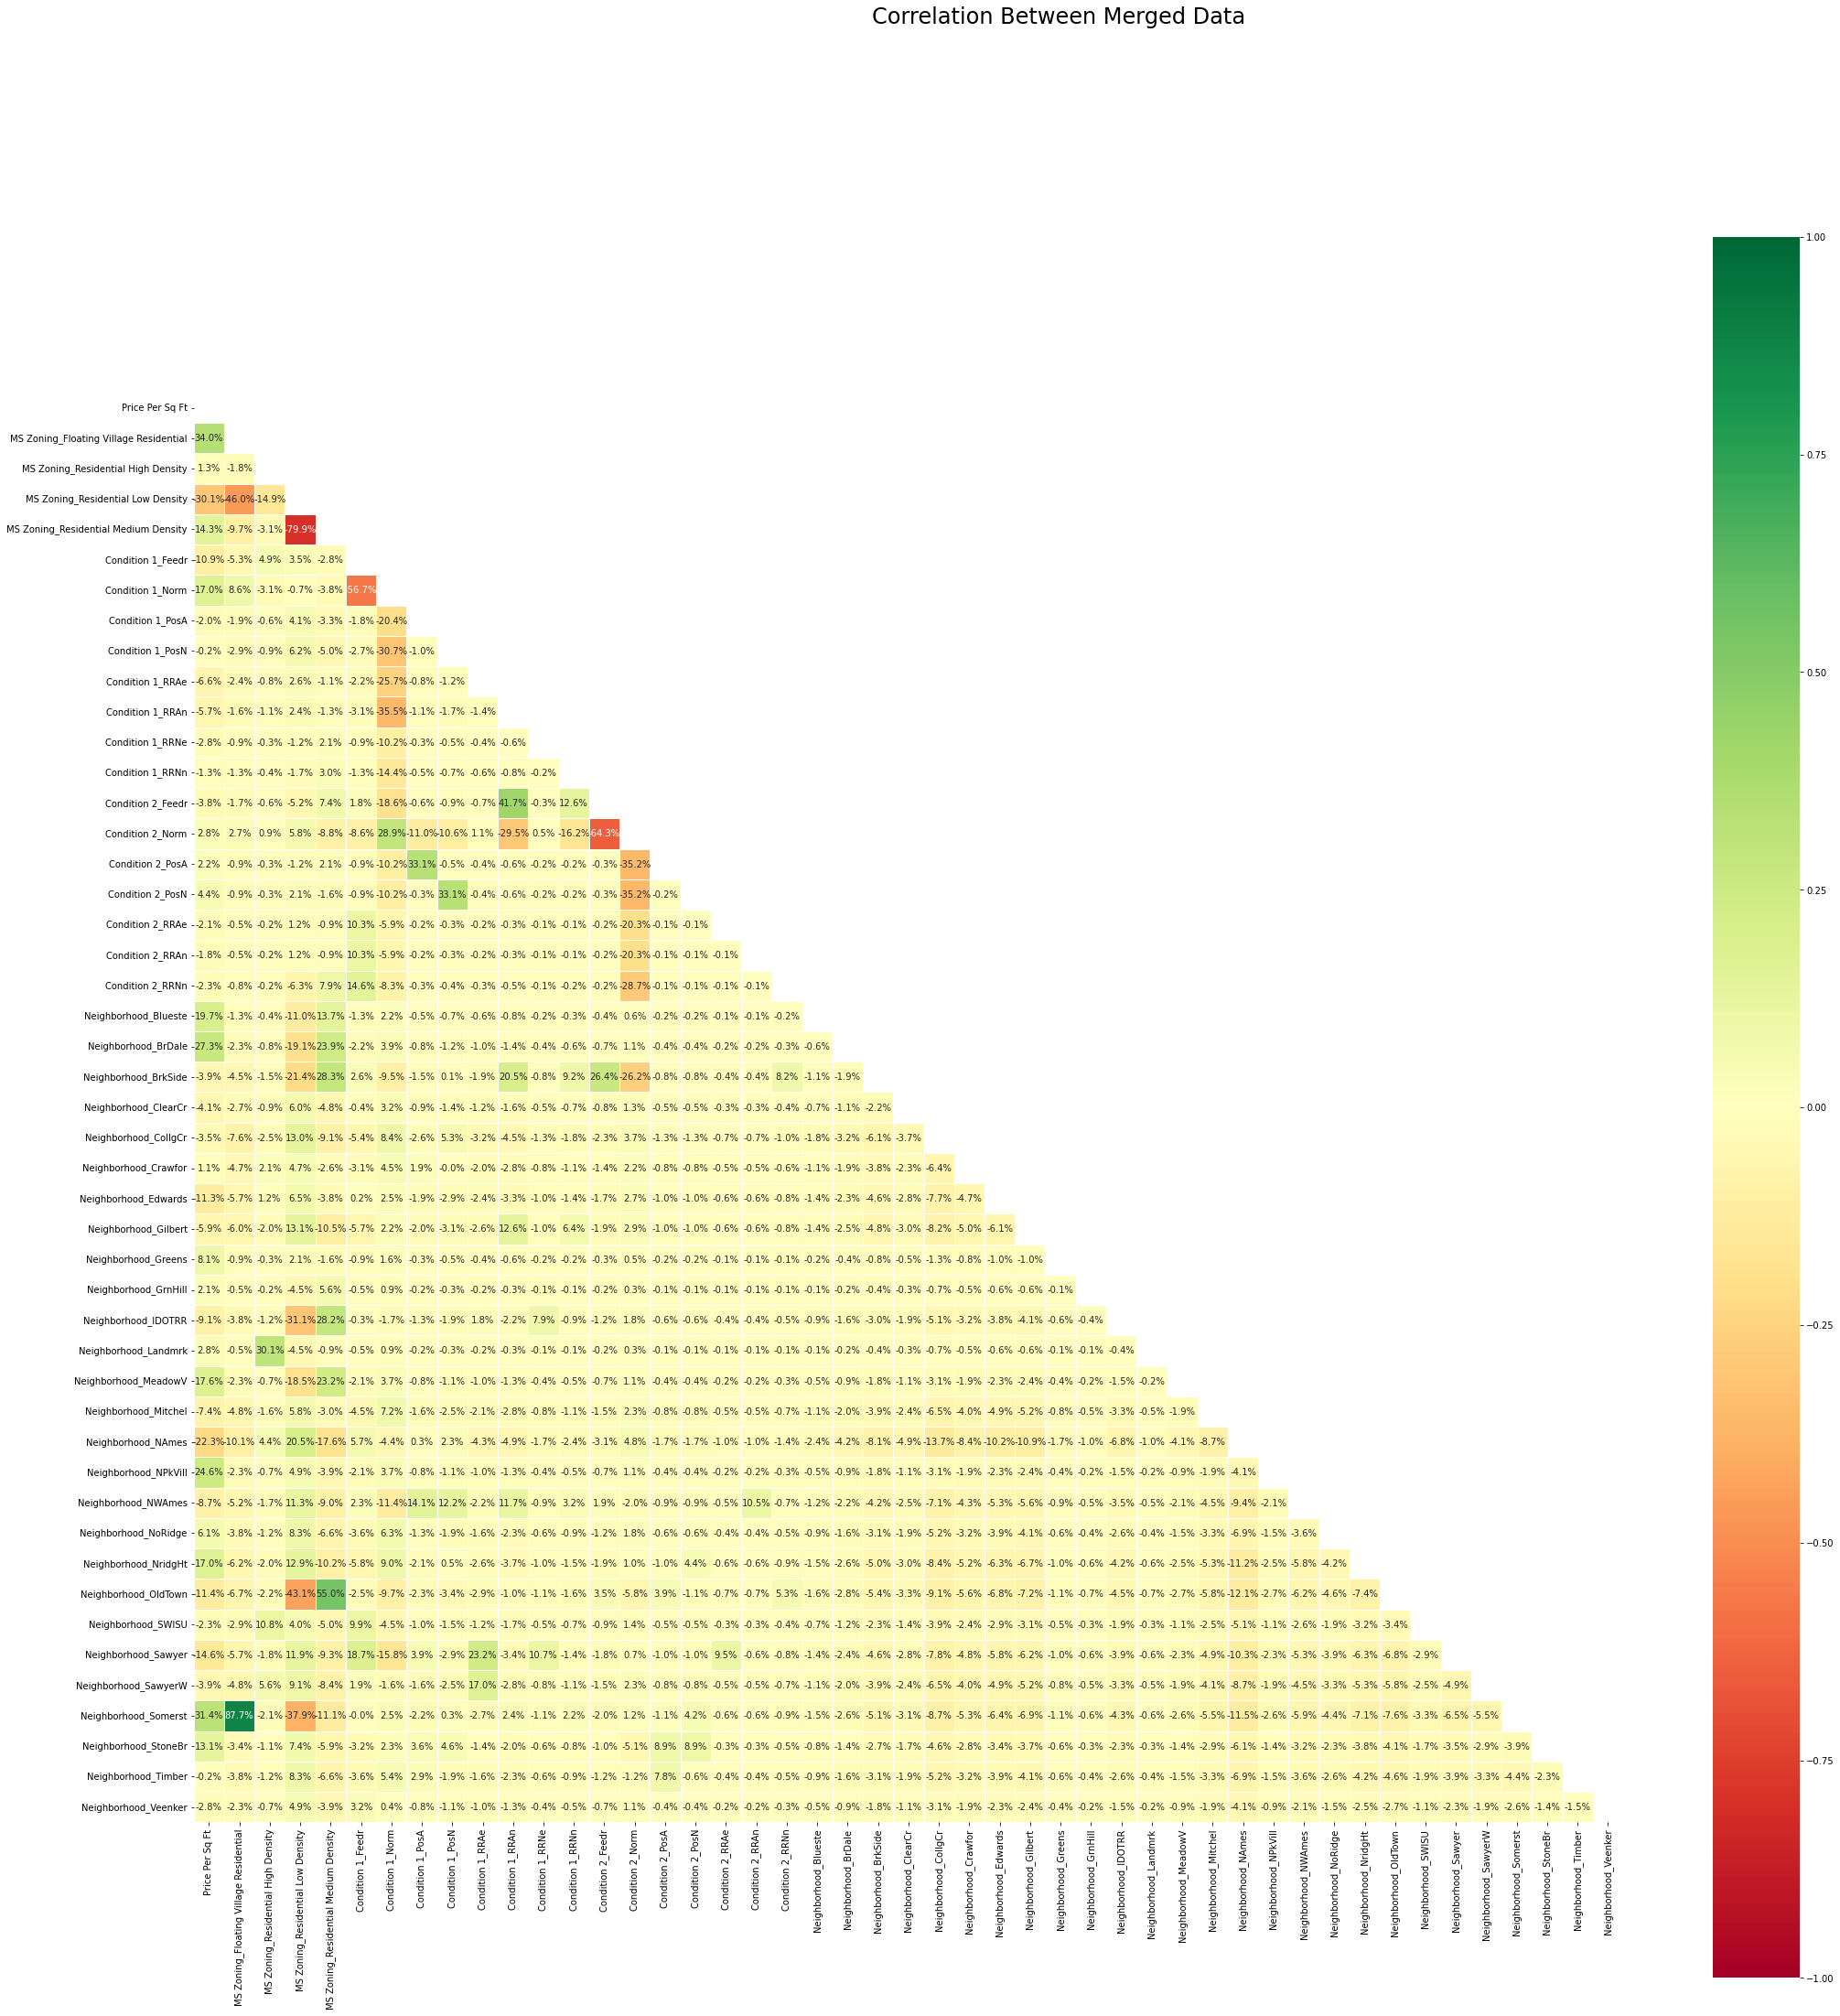

In [2763]:
plot=plt.figure(figsize = (35,35))
plot.suptitle("Correlation Between Merged Data",size=24)
data_corr=zone_condition_df.corr()
mask = np.zeros_like(data_corr)
mask[np.triu_indices_from(mask)] = True
ax=sns.heatmap(data_corr, mask = mask, square = True, annot = True, fmt=".1%", vmin = -1, vmax = 1, linewidths = .5,cmap="RdYlGn")

### Summary of Zone and Neighbourhood Factors

In [2764]:
zone_condition_df.corr()['Price Per Sq Ft'].sort_values()

MS Zoning_Residential Low Density        -0.301127
Neighborhood_NAmes                       -0.223229
Neighborhood_Sawyer                      -0.146110
Neighborhood_OldTown                     -0.114027
Neighborhood_Edwards                     -0.113350
Condition 1_Feedr                        -0.108601
Neighborhood_IDOTRR                      -0.091133
Neighborhood_NWAmes                      -0.087419
Neighborhood_Mitchel                     -0.073864
Condition 1_RRAe                         -0.066481
Neighborhood_Gilbert                     -0.058813
Condition 1_RRAn                         -0.057425
Neighborhood_ClearCr                     -0.040779
Neighborhood_SawyerW                     -0.039443
Neighborhood_BrkSide                     -0.039131
Condition 2_Feedr                        -0.037576
Neighborhood_CollgCr                     -0.035066
Neighborhood_Veenker                     -0.028300
Condition 1_RRNe                         -0.027517
Neighborhood_SWISU             

In [2765]:
zone_condition_df.corr()['Price Per Sq Ft'].sort_values(ascending=False)

Price Per Sq Ft                           1.000000
MS Zoning_Floating Village Residential    0.340090
Neighborhood_Somerst                      0.313665
Neighborhood_BrDale                       0.272756
Neighborhood_NPkVill                      0.246319
Neighborhood_Blueste                      0.197461
Neighborhood_MeadowV                      0.176224
Neighborhood_NridgHt                      0.170338
Condition 1_Norm                          0.169933
MS Zoning_Residential Medium Density      0.143416
Neighborhood_StoneBr                      0.131256
Neighborhood_Greens                       0.081191
Neighborhood_NoRidge                      0.060853
Condition 2_PosN                          0.043665
Condition 2_Norm                          0.028186
Neighborhood_Landmrk                      0.027892
Condition 2_PosA                          0.021940
Neighborhood_GrnHill                      0.020603
MS Zoning_Residential High Density        0.012900
Neighborhood_Crawfor           

MS Zoning_Residential Low Density        -0.301127

Neighborhood_NAmes                       -0.223229

MS Zoning_Floating Village Residential    0.340090

Neighborhood_Somerst                      0.313665

Neighborhood_Blmngtn                      0.312134

Neighborhood_BrDale                       0.272756

Neighborhood_NPkVill                      0.246319

## Sub-Factor 1B: Land Factors

In [2766]:
location_proximity_price_df.columns

Index(['MS SubClass', 'MS Zoning', 'Lot Config', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'Land Contour', 'Land Slope', 'Street',
       'Lot Shape', 'Sale Type', 'SalePrice', 'Price Per Sq Ft'],
      dtype='object')

In [2767]:
land_df = location_proximity_price_df[['Land Contour', 'Land Slope', 'Street','Lot Shape', 'Price Per Sq Ft', 'Lot Config','Bldg Type']]
land_df = pd.get_dummies(location_proximity_price_df,columns=['Land Contour', 'Land Slope', 'Street', 'Lot Shape', 'Lot Config','Bldg Type'])

In [2768]:
land_df.corr()

,SalePrice,Price Per Sq Ft,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Land Slope_Gtl,Land Slope_Mod,Land Slope_Sev,Street_Grvl,...,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE
SalePrice,1.000000,0.271195,-0.099421,0.218441,0.059192,-0.114501,-0.072480,0.069669,0.019195,-0.057952,...,-0.007320,0.163371,-0.012310,0.021494,-8.384005e-02,0.073871,-0.094669,-4.479312e-02,-0.114786,0.043013
Price Per Sq Ft,0.271195,1.000000,-0.097089,0.122387,-0.097536,0.022312,0.022527,0.000848,-0.072938,-0.046777,...,-0.130569,-0.080020,0.059191,-0.018496,1.363747e-01,-0.622710,-0.089883,-5.141445e-02,0.542174,0.524391
Land Contour_Bnk,-0.099421,-0.097089,1.000000,-0.041210,-0.027343,-0.582964,-0.167477,0.166514,0.027885,0.052911,...,0.002445,-0.040065,-0.032868,-0.012616,3.443502e-02,0.034617,0.089084,-6.835859e-03,-0.035637,-0.058650
Land Contour_HLS,0.218441,0.122387,-0.041210,1.000000,-0.030143,-0.642646,-0.301771,0.309199,0.022972,-0.009824,...,-0.007440,0.047742,-0.020501,-0.013908,-1.075676e-02,-0.046872,-0.027091,7.351898e-03,-0.024704,0.085065
Land Contour_Low,0.059192,-0.097536,-0.027343,-0.030143,1.000000,-0.426401,-0.464938,0.398368,0.267597,-0.006518,...,-0.023848,0.100648,-0.024041,-0.009228,-2.581989e-02,0.038762,0.012583,7.567568e-03,-0.026066,-0.042898
Land Contour_Lvl,-0.114501,0.022312,-0.582964,-0.642646,-0.426401,1.000000,0.526120,-0.499698,-0.157240,-0.023277,...,0.014617,-0.054288,0.045647,0.021641,-2.158752e-03,-0.007598,-0.042922,-4.264014e-03,0.051181,-0.001553
Land Slope_Gtl,-0.072480,0.022527,-0.167477,-0.301771,-0.464938,0.526120,1.000000,-0.947456,-0.305782,-0.043070,...,0.037823,-0.028750,0.038486,0.014772,-3.249763e-02,-0.007126,-0.030245,3.201671e-02,0.041728,-0.019915
Land Slope_Mod,0.069669,0.000848,0.166514,0.309199,0.398368,-0.499698,-0.947456,1.000000,-0.014849,0.046304,...,-0.035985,-0.005176,-0.036464,-0.013996,4.906993e-02,-0.002388,0.034719,-3.033443e-02,-0.039535,0.027970
Land Slope_Sev,0.019195,-0.072938,0.027885,0.022972,0.267597,-0.157240,-0.305782,-0.014849,1.000000,-0.003191,...,-0.011122,0.105272,-0.011768,-0.004517,-4.447057e-02,0.029380,-0.008799,-9.790130e-03,-0.012760,-0.020999
Street_Grvl,-0.057952,-0.046777,0.052911,-0.009824,-0.006518,-0.023277,-0.043070,0.046304,-0.003191,1.000000,...,0.009569,-0.012276,-0.007835,-0.003007,2.103702e-03,0.019560,-0.005858,-6.518082e-03,-0.008495,-0.013981


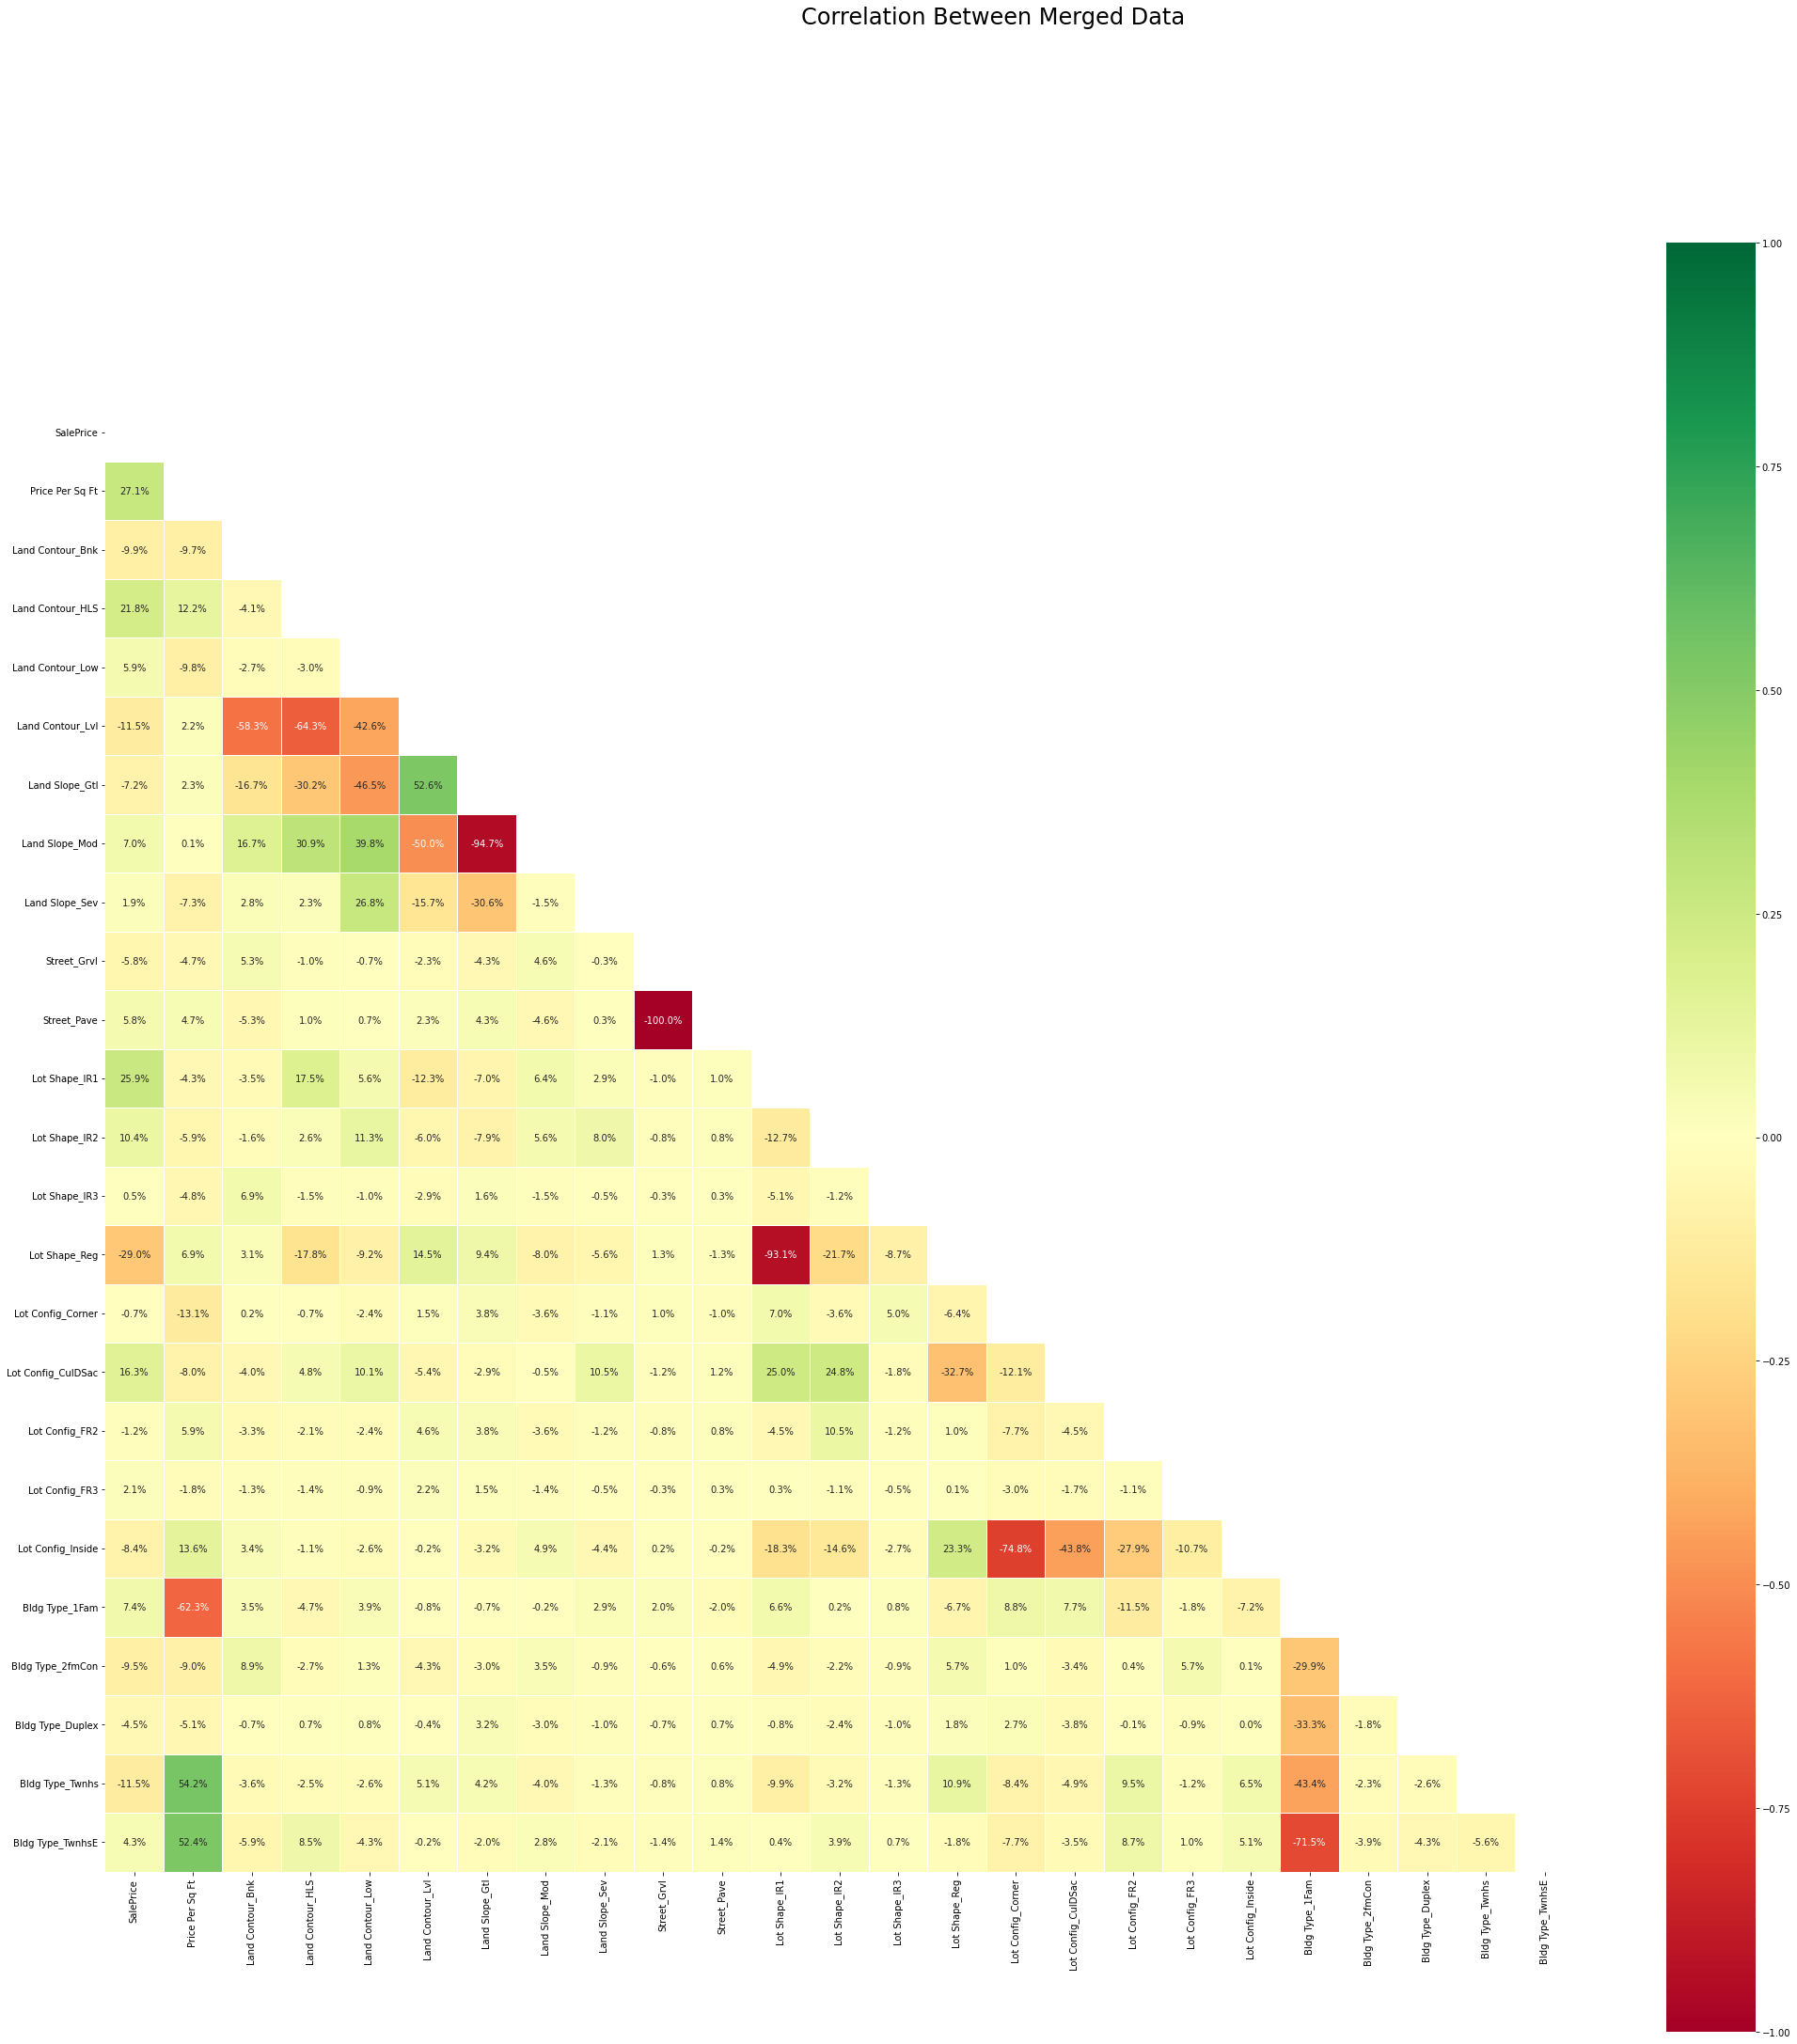

In [2769]:
plot=plt.figure(figsize = (35,35))
plot.suptitle("Correlation Between Merged Data",size=24)
data_corr=land_df.corr()
mask = np.zeros_like(data_corr)
mask[np.triu_indices_from(mask)] = True
ax=sns.heatmap(data_corr, mask = mask, square = True, annot = True, fmt=".1%", vmin = -1, vmax = 1, linewidths = .5,cmap="RdYlGn")

### Summary of Land Factors

In [2770]:
land_df.corr()['Price Per Sq Ft'].sort_values()

Bldg Type_1Fam       -0.622710
Lot Config_Corner    -0.130569
Land Contour_Low     -0.097536
Land Contour_Bnk     -0.097089
Bldg Type_2fmCon     -0.089883
Lot Config_CulDSac   -0.080020
Land Slope_Sev       -0.072938
Lot Shape_IR2        -0.058519
Bldg Type_Duplex     -0.051414
Lot Shape_IR3        -0.048025
Street_Grvl          -0.046777
Lot Shape_IR1        -0.043172
Lot Config_FR3       -0.018496
Land Slope_Mod        0.000848
Land Contour_Lvl      0.022312
Land Slope_Gtl        0.022527
Street_Pave           0.046777
Lot Config_FR2        0.059191
Lot Shape_Reg         0.069209
Land Contour_HLS      0.122387
Lot Config_Inside     0.136375
SalePrice             0.271195
Bldg Type_TwnhsE      0.524391
Bldg Type_Twnhs       0.542174
Price Per Sq Ft       1.000000
Name: Price Per Sq Ft, dtype: float64

In [2771]:
land_df.corr()['Price Per Sq Ft'].sort_values(ascending=False)

Price Per Sq Ft       1.000000
Bldg Type_Twnhs       0.542174
Bldg Type_TwnhsE      0.524391
SalePrice             0.271195
Lot Config_Inside     0.136375
Land Contour_HLS      0.122387
Lot Shape_Reg         0.069209
Lot Config_FR2        0.059191
Street_Pave           0.046777
Land Slope_Gtl        0.022527
Land Contour_Lvl      0.022312
Land Slope_Mod        0.000848
Lot Config_FR3       -0.018496
Lot Shape_IR1        -0.043172
Street_Grvl          -0.046777
Lot Shape_IR3        -0.048025
Bldg Type_Duplex     -0.051414
Lot Shape_IR2        -0.058519
Land Slope_Sev       -0.072938
Lot Config_CulDSac   -0.080020
Bldg Type_2fmCon     -0.089883
Land Contour_Bnk     -0.097089
Land Contour_Low     -0.097536
Lot Config_Corner    -0.130569
Bldg Type_1Fam       -0.622710
Name: Price Per Sq Ft, dtype: float64

Bldg Type_1Fam       -0.622710

Lot Config_Corner    -0.130569

Bldg Type_Twnhs       0.542174

Bldg Type_TwnhsE      0.524391

SalePrice             0.271195

## Sub-Factor 1C: MS Subclass Factors

In [2772]:
ms_subclass_df = location_proximity_price_df[['Price Per Sq Ft', 'MS SubClass']]
ms_subclass_df = pd.get_dummies(location_proximity_price_df,columns=['MS SubClass'], drop_first=True)

In [2773]:
ms_subclass_df.corr()

,SalePrice,Price Per Sq Ft,MS SubClass_1 Storey Newer All,MS SubClass_1 Storey PUD,MS SubClass_1 Storey W/Finished Attic,MS SubClass_1.5 Finished,MS SubClass_1.5 Storey PUD,MS SubClass_1.5 Unfinished,MS SubClass_2 Storey 1946 Newer,MS SubClass_2 Storey 1946 Older,MS SubClass_2 Storey PUD,MS SubClass_2.5 Story All,MS SubClass_Duplex All,MS SubClass_Family Conversion,MS SubClass_PUD Multi,MS SubClass_Split,MS SubClass_Split Foyer
SalePrice,1.000000,0.271195,0.055966,0.083473,-0.040061,-0.191496,-0.011458,-0.060633,0.337426,-0.088395,-0.125866,0.032893,-0.044793,-0.091872,-0.055173,-0.050011,-0.053275
Price Per Sq Ft,0.271195,1.000000,-0.249424,0.455424,-0.018491,-0.128728,0.115060,-0.018720,-0.000270,-0.042571,0.568168,-0.030436,-0.051414,-0.090446,0.135922,-0.097095,-0.055449
MS SubClass_1 Storey Newer All,0.055966,-0.249424,1.000000,-0.216712,-0.036569,-0.257649,-0.018270,-0.054927,-0.405632,-0.169113,-0.170189,-0.068597,-0.112208,-0.100847,-0.051772,-0.173381,-0.095595
MS SubClass_1 Storey PUD,0.083473,0.455424,-0.216712,1.000000,-0.012589,-0.088694,-0.006289,-0.018908,-0.139636,-0.058216,-0.058586,-0.023614,-0.038627,-0.034716,-0.017822,-0.059685,-0.032908
MS SubClass_1 Storey W/Finished Attic,-0.040061,-0.018491,-0.036569,-0.012589,1.000000,-0.014967,-0.001061,-0.003191,-0.023563,-0.009824,-0.009886,-0.003985,-0.006518,-0.005858,-0.003007,-0.010072,-0.005553
MS SubClass_1.5 Finished,-0.191496,-0.128728,-0.257649,-0.088694,-0.014967,1.000000,-0.007477,-0.022480,-0.166013,-0.069213,-0.069653,-0.028075,-0.045923,-0.041274,-0.021189,-0.070960,-0.039124
MS SubClass_1.5 Storey PUD,-0.011458,0.115060,-0.018270,-0.006289,-0.001061,-0.007477,1.000000,-0.001594,-0.011772,-0.004908,-0.004939,-0.001991,-0.003256,-0.002927,-0.001502,-0.005032,-0.002774
MS SubClass_1.5 Unfinished,-0.060633,-0.018720,-0.054927,-0.018908,-0.003191,-0.022480,-0.001594,1.000000,-0.035391,-0.014755,-0.014849,-0.005985,-0.009790,-0.008799,-0.004517,-0.015127,-0.008341
MS SubClass_2 Storey 1946 Newer,0.337426,-0.000270,-0.405632,-0.139636,-0.023563,-0.166013,-0.011772,-0.035391,1.000000,-0.108966,-0.109659,-0.044200,-0.072300,-0.064980,-0.033358,-0.111716,-0.061595
MS SubClass_2 Storey 1946 Older,-0.088395,-0.042571,-0.169113,-0.058216,-0.009824,-0.069213,-0.004908,-0.014755,-0.108966,1.000000,-0.045718,-0.018427,-0.030143,-0.027091,-0.013908,-0.046576,-0.025680


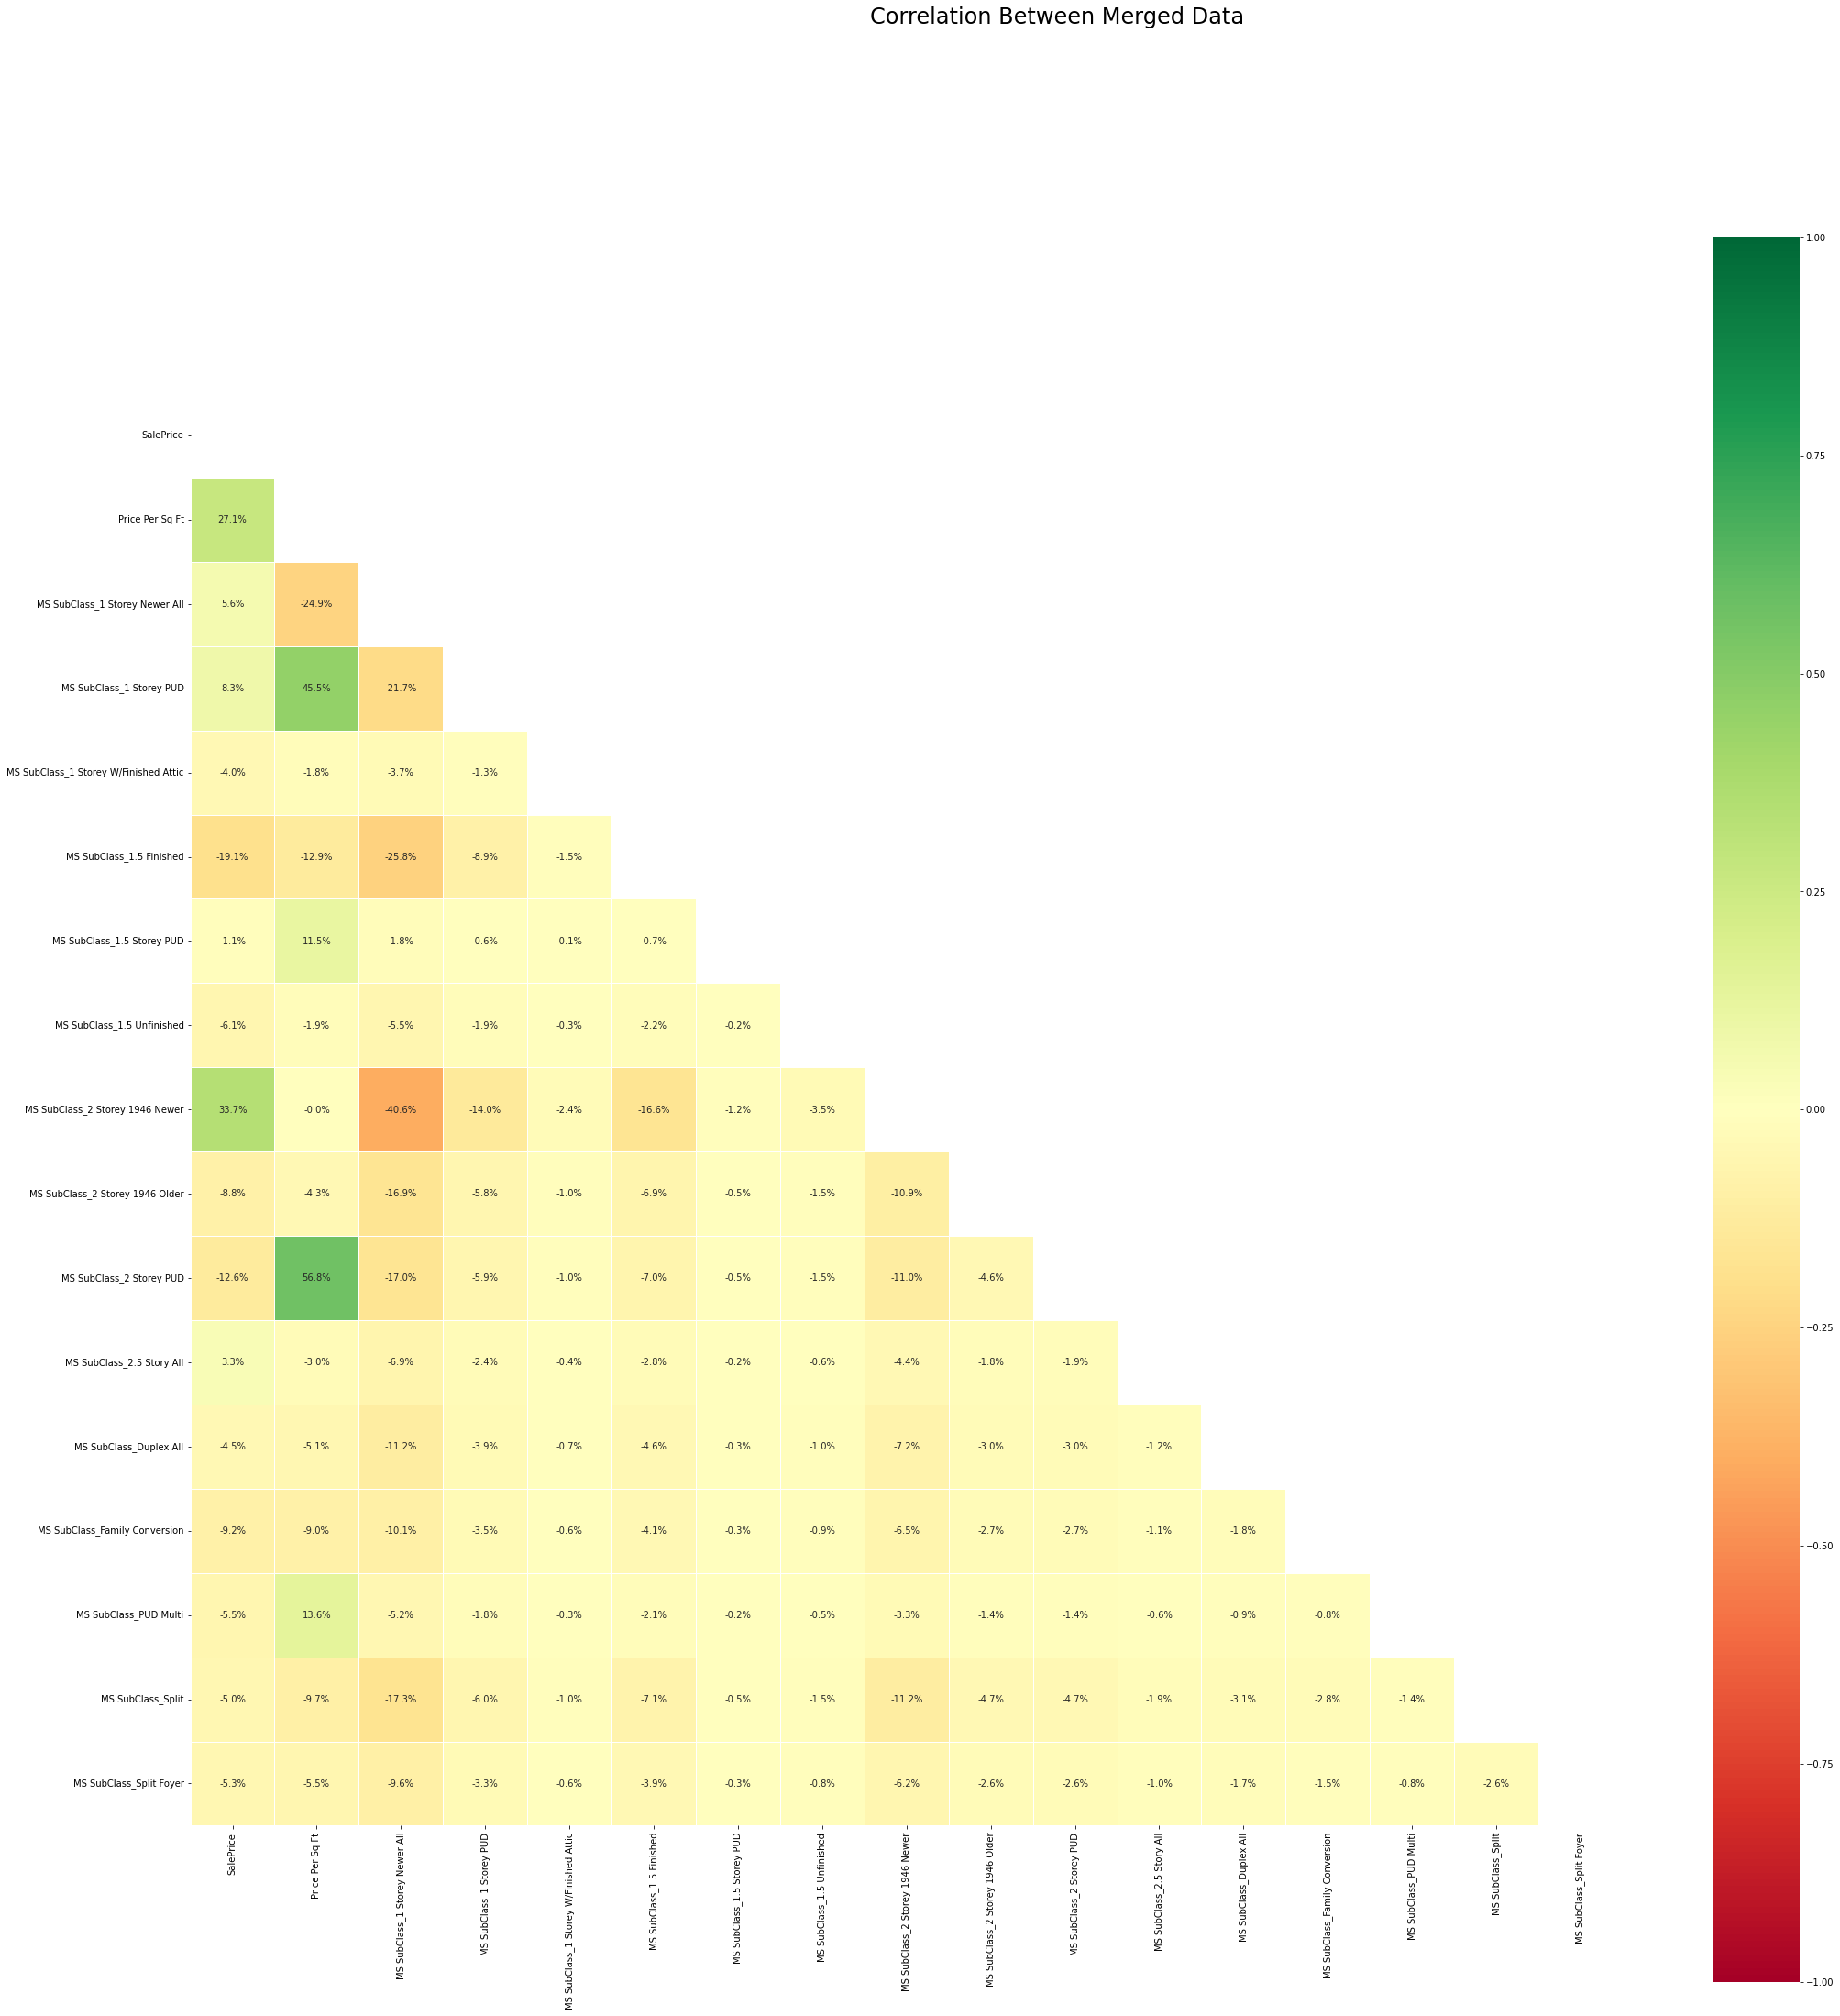

In [2774]:
plot=plt.figure(figsize = (35,35))
plot.suptitle("Correlation Between Merged Data",size=24)
data_corr=ms_subclass_df.corr()
mask = np.zeros_like(data_corr)
mask[np.triu_indices_from(mask)] = True
ax=sns.heatmap(data_corr, mask = mask, square = True, annot = True, fmt=".1%", vmin = -1, vmax = 1, linewidths = .5,cmap="RdYlGn")

### Summary of MS Subclass Factors

In [2775]:
ms_subclass_df.corr()['Price Per Sq Ft'].sort_values()

MS SubClass_1 Storey Newer All          -0.249424
MS SubClass_1.5 Finished                -0.128728
MS SubClass_Split                       -0.097095
MS SubClass_Family Conversion           -0.090446
MS SubClass_Split Foyer                 -0.055449
MS SubClass_Duplex All                  -0.051414
MS SubClass_2 Storey 1946 Older         -0.042571
MS SubClass_2.5 Story All               -0.030436
MS SubClass_1.5 Unfinished              -0.018720
MS SubClass_1 Storey W/Finished Attic   -0.018491
MS SubClass_2 Storey 1946 Newer         -0.000270
MS SubClass_1.5 Storey PUD               0.115060
MS SubClass_PUD Multi                    0.135922
SalePrice                                0.271195
MS SubClass_1 Storey PUD                 0.455424
MS SubClass_2 Storey PUD                 0.568168
Price Per Sq Ft                          1.000000
Name: Price Per Sq Ft, dtype: float64

MS SubClass_1 Storey Newer All          -0.249424

MS SubClass_1 Storey PUD                 0.455424

MS SubClass_2 Storey PUD                 0.568168

## Model Location and Proximity Factors using OLS Regression

### Zone and Neighbourhood Factors

#### Model Using sklearn

In [2776]:
zone_condition_df.head()

,Price Per Sq Ft,MS Zoning_Floating Village Residential,MS Zoning_Residential High Density,MS Zoning_Residential Low Density,MS Zoning_Residential Medium Density,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,9.654509,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,19.143752,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,13.759152,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,17.751479,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,9.729540,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [2777]:
X_train, X_test, y_train, y_test = train_test_split(zone_condition_df.dropna().drop(columns=['Price Per Sq Ft']),
                                                    zone_condition_df.dropna()['Price Per Sq Ft'],
                                                    test_size=0.2,
                                                    random_state=123)

In [2778]:
# Step 1. Instantiate the model.
model = LinearRegression()

# Step 2. Fit the model on the training data.
model.fit(X_train, y_train)

# Step 3. Generate predictions.
preds = model.predict(X_test)

In [2779]:

# Check the MSE on the training and testing sets.

print(f'MSE on testing set: {mean_squared_error(y_train, model.predict(X_train))}')
print(f'MSE on training set: {mean_squared_error(y_test, preds)}')

MSE on testing set: 64.85765424913346
MSE on training set: 66.35510131259922


In [2780]:
# Check the R^2 on the training and testing sets.

print(f'R^2 on testing set: {r2_score(y_train, model.predict(X_train))}')
print(f'R^2 on training set: {r2_score(y_test, preds)}')

R^2 on testing set: 0.6316345195137942
R^2 on training set: 0.5449978994326972


In [2781]:
#print(model.score(y_train, model.predict(X_train)))
#print(model.score(y_test, preds))

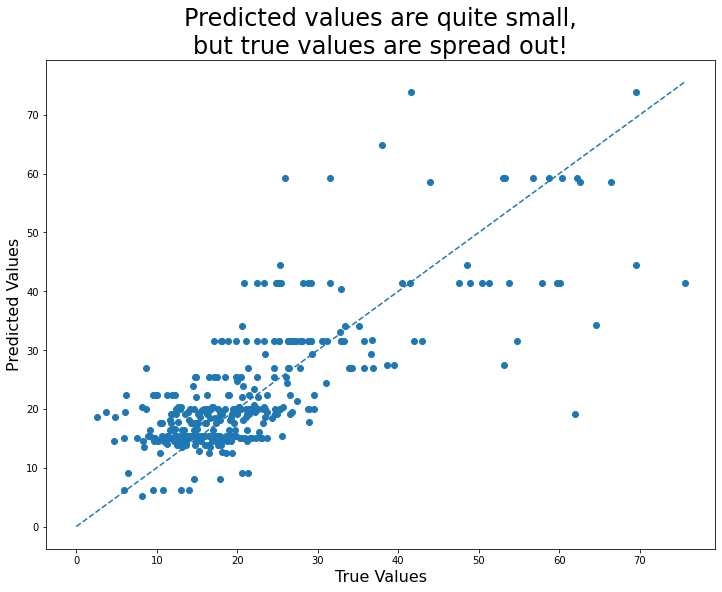

In [2782]:
plt.figure(figsize = (12, 9))

# Examine the relationship between observed and predicted values.
plt.scatter(y_test, preds)

# Line showing perfect predictions.
plt.plot([0, max(max(y_test),max(preds))],
         [0, max(max(y_test),max(preds))],
         linestyle = '--')

plt.title('Predicted values are quite small,\nbut true values are spread out!', fontsize = 24)
plt.xlabel('True Values', fontsize = 16)
plt.ylabel('Predicted Values', fontsize = 16);

In [2783]:
print(f'MSE of baseline model: {mean_squared_error(y_test, [np.mean(y_train)] * len(y_test))}')

MSE of baseline model: 146.1055341285836


In [2784]:
print(f'R^2 of baseline model: {r2_score(y_test, [np.mean(y_train)] * len(y_test))}')

R^2 of baseline model: -0.0018570331139060592


#### Model Using statsmodels

In [2785]:
# Remember, we need to add a constant in statsmodels!
X_train = sm.add_constant(X_train)

In [2786]:
model_sm = sm.OLS(y_train, X_train).fit()

In [2787]:
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Price Per Sq Ft   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     55.75
Date:                Sat, 15 Oct 2022   Prob (F-statistic):          6.26e-281
Time:                        16:40:27   Log-Likelihood:                -5289.1
No. Observations:                1509   AIC:                         1.067e+04
Df Residuals:                    1463   BIC:                         1.091e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                     62.1485      5.972     10.406      0.000      50.433      73.864
MS Zoning_Floating Village Residential    10.0411      4.024      2.495      0.013       2.148      17.935
MS Zoning_Residential High Density        -0.5794      4.557     -0.127      0.899      -9.519       8.360
MS Zoning_Residential Low Density         -6.9752      3.505     -1.990      0.047     -13.850      -0.100
MS Zoning_Residential Medium Density       6.0262      3.297      1.828      0.068      -0.441      12.494
Condition 1_Feedr                         -0.5438      1.656     -0.328      0.743      -3.792       2.705
Condition 1_Norm                           1.0296      1.289      0.799      0.424      -1.498       3.557
Condition 1_PosA                          -0.5076      2.933     -0.173      0.863      -6.260       5.245
Condition 1_PosN                           1.2834      2.254      0.569      0.569      -3.138       5.705
Condition 1_RRAe                          -2.6352      2.475     -1.065      0.287      -7.490       2.220
Condition 1_RRAn                           0.0082      2.169      0.004      0.997      -4.247       4.264
Condition 1_RRNe                          -0.8898      4.956     -0.180      0.858     -10.611       8.831
Condition 1_RRNn                          -1.8966      4.057     -0.468      0.640      -9.854       6.061
Condition 2_Feedr                         -0.9463      5.298     -0.179      0.858     -11.340       9.447
Condition 2_Norm                           2.3465      4.379      0.536      0.592      -6.244      10.937
Condition 2_PosA                           7.9002      6.679      1.183      0.237      -5.202      21.002
Condition 2_PosN                           8.4990      6.738      1.261      0.207      -4.717      21.715
Condition 2_RRAe                          -1.0713      9.362     -0.114      0.909     -19.437      17.294
Condition 2_RRAn                          -1.7250      9.397     -0.184      0.854     -20.158      16.708
Condition 2_RRNn                          -5.3933      7.305     -0.738      0.460     -19.724       8.937
Neighborhood_Blueste                       2.2575      4.622      0.488      0.625      -6.809      11.324
Neighborhood_BrDale                      -12.3627      3.017     -4.098      0.000     -18.280      -6.445
Neighborhood_BrkSide                     -46.0799      2.403    -19.174      0.000     -50.794     -41.366
Neighborhood_ClearCr                     -39.9045      2.624    -15.209      0.000     -45.051     -34.758
Neighborhood_CollgCr                     -38.5277      2.001    -19.257      0.000     -42.452     -34.603
Neighborhood_Crawfor                     -36.2390      2.173    -16.676      0.000     

### Land Factors

In [2788]:
land_df.head()

,MS SubClass,MS Zoning,Neighborhood,Condition 1,Condition 2,Sale Type,SalePrice,Price Per Sq Ft,Land Contour_Bnk,Land Contour_HLS,...,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE
0,2 Storey 1946 Newer,Residential Low Density,Sawyer,RRAe,Norm,WD,130500,9.654509,0,0,...,0,1,0,0,0,1,0,0,0,0
1,2 Storey 1946 Newer,Residential Low Density,SawyerW,Norm,Norm,WD,220000,19.143752,0,0,...,0,1,0,0,0,1,0,0,0,0
2,1 Storey Newer All,Residential Low Density,NAmes,Norm,Norm,WD,109000,13.759152,0,0,...,0,0,0,0,1,1,0,0,0,0
3,2 Storey 1946 Newer,Residential Low Density,Timber,Norm,Norm,WD,174000,17.751479,0,0,...,0,0,0,0,1,1,0,0,0,0
4,1.5 Finished,Residential Low Density,SawyerW,Norm,Norm,WD,138500,9.729540,0,0,...,0,0,0,0,1,1,0,0,0,0


### MS Subclass Factors

In [2789]:
ms_subclass_df.head()

,MS Zoning,Lot Config,Neighborhood,Condition 1,Condition 2,Bldg Type,Land Contour,Land Slope,Street,Lot Shape,...,MS SubClass_1.5 Unfinished,MS SubClass_2 Storey 1946 Newer,MS SubClass_2 Storey 1946 Older,MS SubClass_2 Storey PUD,MS SubClass_2.5 Story All,MS SubClass_Duplex All,MS SubClass_Family Conversion,MS SubClass_PUD Multi,MS SubClass_Split,MS SubClass_Split Foyer
0,Residential Low Density,CulDSac,Sawyer,RRAe,Norm,1Fam,Lvl,Gtl,Pave,IR1,...,0,1,0,0,0,0,0,0,0,0
1,Residential Low Density,CulDSac,SawyerW,Norm,Norm,1Fam,Lvl,Gtl,Pave,IR1,...,0,1,0,0,0,0,0,0,0,0
2,Residential Low Density,Inside,NAmes,Norm,Norm,1Fam,Lvl,Gtl,Pave,Reg,...,0,0,0,0,0,0,0,0,0,0
3,Residential Low Density,Inside,Timber,Norm,Norm,1Fam,Lvl,Gtl,Pave,Reg,...,0,1,0,0,0,0,0,0,0,0
4,Residential Low Density,Inside,SawyerW,Norm,Norm,1Fam,Lvl,Gtl,Pave,IR1,...,0,0,0,0,0,0,0,0,0,0


# Factor 2: Quality and Condition of Home

In [2790]:
price_factors_df.drop(['Sale Type','SalePrice'], axis=1, inplace=True)
price_factors_df.head()

,Price Per Sq Ft
0,9.654509
1,19.143752
2,13.759152
3,17.751479
4,9.729540


In [2791]:
quality_condition_df.drop('Unnamed: 0', axis=1, inplace=True)
# quality_condition_price_df = location_proximity_df.join(price_factors_df, how='outer')
print(quality_condition_df.shape)
quality_condition_df.head(3)

(1887, 7)


,Overall Quality,Overall Condition,Exterior Quality,Exterior Condition,Functional,Garage Qual,Garage Cond
0,6,8,4,3,Typ,TA,TA
1,7,5,4,3,Typ,TA,TA
2,5,7,3,4,Typ,TA,TA


In [2792]:
X2 = quality_condition_df
y2 = price_factors_df

In [2793]:
X2 = pd.get_dummies(drop_first=True, data=X2)
X2.head()

,Overall Quality,Overall Condition,Exterior Quality,Exterior Condition,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Garage Qual_Fa,Garage Qual_Gd,Garage Qual_Po,Garage Qual_TA,Garage Cond_Fa,Garage Cond_Gd,Garage Cond_Po,Garage Cond_TA
0,6,8,4,3,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
1,7,5,4,3,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
2,5,7,3,4,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
3,5,5,3,3,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
4,6,8,3,3,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1


In [2794]:
X2.shape

(1887, 19)

### Step 2: Instantiate the model

In [2795]:
model2 = LinearRegression()

### Step 3: Fit the model

In [2796]:
model2.fit(X2,y2)

LinearRegression()

### Step 4: Check out and interpret our coefficients

In [2797]:
for i in X2.columns:
    print (i)

Overall Quality
Overall Condition
Exterior Quality
Exterior Condition
Functional_Maj2
Functional_Min1
Functional_Min2
Functional_Mod
Functional_Sal
Functional_Sev
Functional_Typ
Garage Qual_Fa
Garage Qual_Gd
Garage Qual_Po
Garage Qual_TA
Garage Cond_Fa
Garage Cond_Gd
Garage Cond_Po
Garage Cond_TA


In [2798]:
model2.coef_

array([[  2.50230015,  -0.42876963,   3.55971304,  -1.01740776,
        -12.86829656,  -9.08154607,  -8.66780566, -12.89365284,
        -15.80280806, -18.68481968,  -6.17826386,  10.12168182,
         13.36226929,   3.26882522,  10.65509311,  -7.77105886,
        -11.56426303,  -9.46265543,  -7.55655787]])

In [2799]:
model2_coef = dict(zip(X2.columns, model2.coef_))


In [2800]:
{k: v for k, v in sorted(model2_coef.items(), key=lambda item: item[1], reverse=True)}


{'Overall Quality': array([  2.50230015,  -0.42876963,   3.55971304,  -1.01740776,
        -12.86829656,  -9.08154607,  -8.66780566, -12.89365284,
        -15.80280806, -18.68481968,  -6.17826386,  10.12168182,
         13.36226929,   3.26882522,  10.65509311,  -7.77105886,
        -11.56426303,  -9.46265543,  -7.55655787])}

Interpretation of Coefficients

Key Findings:
- 'Garage Qual_Gd': 13.362269290041825,
- 'Garage Qual_TA': 10.655093109673714,
- 'Garage Qual_Fa': 10.121681818748726,
- 'Exterior Quality': 3.559713042651744,
- 'Garage Qual_Po': 3.2688252152673734,
- 'Overall Quality': 2.5023001456502363,

### Step 5: Make predictions

In [2801]:
X2.head(3)

,Overall Quality,Overall Condition,Exterior Quality,Exterior Condition,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Garage Qual_Fa,Garage Qual_Gd,Garage Qual_Po,Garage Qual_TA,Garage Cond_Fa,Garage Cond_Gd,Garage Cond_Po,Garage Cond_TA
0,6,8,4,3,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
1,7,5,4,3,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
2,5,7,3,4,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1


In [2802]:
y2_preds = model2.predict(X2)
y2_preds # y_preds are points on the regression plane 
# y_preds are the predicted riders data

array([[22.78923767],
       [26.57784669],
       [16.13858635],
       ...,
       [19.3391516 ],
       [15.51123321],
       [23.01813365]])

### Step 6: Evaluate the model

In [2803]:
metrics.r2_score(y2, y2_preds)

0.18554899368182243

Only 18.5% of the data fall on the regression line. Terrible score.

In [2804]:
metrics.mean_squared_error(y2, y2_preds) # the error is HUGE

138.50205407247103

How is our model?

# Factor 3: Parts of the Home

In [2805]:
price_factors_df

,Price Per Sq Ft
0,9.654509
1,19.143752
2,13.759152
3,17.751479
4,9.729540
...,...
1882,26.094069
1883,6.684492
1884,23.418894
1885,13.846154


In [2806]:
price_factors_df['Price Per Sq Ft'].sort_values()

1492     1.324461
438      1.742138
880      2.504422
641      2.622689
684      2.797203
          ...    
376     83.845064
1122    84.067393
1389    87.294118
482     87.319666
1385    95.384615
Name: Price Per Sq Ft, Length: 1887, dtype: float64

In [2807]:
parts_of_home_df.drop('Unnamed: 0', axis=1, inplace=True)
parts_of_home_df


,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,...,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Garage Type,Garage Finish,Garage Cars,Paved Drive
0,2Story,Gable,CompShg,HdBoard,Plywood,CBlock,TA,TA,No,GLQ,...,1,3,1,Gd,6,0,Attchd,RFn,2.0,Y
1,2Story,Gable,CompShg,VinylSd,VinylSd,PConc,Gd,TA,No,GLQ,...,1,4,1,Gd,8,1,Attchd,RFn,2.0,Y
2,1Story,Gable,CompShg,VinylSd,VinylSd,CBlock,TA,TA,No,GLQ,...,0,3,1,Gd,5,0,Detchd,Unf,1.0,Y
3,2Story,Gable,CompShg,VinylSd,VinylSd,PConc,Gd,TA,No,Unf,...,1,3,1,TA,7,0,BuiltIn,Fin,2.0,Y
4,1.5Fin,Gable,CompShg,Wd Sdng,Plywood,PConc,Fa,Gd,No,Unf,...,0,3,1,TA,6,0,Detchd,Unf,2.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1882,1Story,Gable,CompShg,VinylSd,VinylSd,PConc,Gd,TA,Av,GLQ,...,0,3,1,Gd,7,1,Attchd,Fin,2.0,Y
1883,1Story,Gable,CompShg,VinylSd,VinylSd,CBlock,TA,TA,No,BLQ,...,0,1,1,TA,4,0,Detchd,Unf,2.0,Y
1884,1.5Fin,Gable,CompShg,BrkFace,Stone,BrkTil,TA,TA,No,Unf,...,1,3,1,TA,9,1,Detchd,Unf,2.0,Y
1885,1Story,Gable,CompShg,Plywood,Plywood,CBlock,TA,TA,No,Rec,...,0,3,1,TA,6,2,Attchd,Unf,1.0,Y


In [2808]:
X3 = parts_of_home_df
y3 = price_factors_df

In [2809]:
X3 = pd.get_dummies(drop_first=True, data=X3)
X3.head()

,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,House Style_1.5Unf,...,Kitchen Qual_TA,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Finish_RFn,Garage Finish_Unf,Paved Drive_P,Paved Drive_Y
0,0.0,0.0,2,1,3,1,6,0,2.0,0,...,0,1,0,0,0,0,1,0,0,1
1,1.0,0.0,2,1,4,1,8,1,2.0,0,...,0,1,0,0,0,0,1,0,0,1
2,1.0,0.0,1,0,3,1,5,0,1.0,0,...,0,0,0,0,0,1,0,1,0,1
3,0.0,0.0,2,1,3,1,7,0,2.0,0,...,1,0,0,1,0,0,0,0,0,1
4,0.0,0.0,2,0,3,1,6,0,2.0,0,...,1,0,0,0,0,1,0,1,0,0


### Step 2: Instantiate the model

In [2810]:
model3 = LinearRegression()

### Step 3: Fit the model

In [2811]:
model3.fit(X3, y3) # X independent, y dependent

LinearRegression()

### Step 4: Check out and interpret our coefficients

In [2812]:
X3.columns

Index(['Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces',
       'Garage Cars', 'House Style_1.5Unf', 'House Style_1Story',
       'House Style_2.5Fin', 'House Style_2.5Unf', 'House Style_2Story',
       'House Style_SFoyer', 'House Style_SLvl', 'Roof Style_Gable',
       'Roof Style_Gambrel', 'Roof Style_Hip', 'Roof Style_Mansard',
       'Roof Style_Shed', 'Roof Matl_CompShg', 'Roof Matl_Membran',
       'Roof Matl_Tar&Grv', 'Roof Matl_WdShake', 'Roof Matl_WdShngl',
       'Exterior 1st_BrkComm', 'Exterior 1st_BrkFace', 'Exterior 1st_CBlock',
       'Exterior 1st_CemntBd', 'Exterior 1st_HdBoard', 'Exterior 1st_ImStucc',
       'Exterior 1st_MetalSd', 'Exterior 1st_Plywood', 'Exterior 1st_Stone',
       'Exterior 1st_Stucco', 'Exterior 1st_VinylSd', 'Exterior 1st_Wd Sdng',
       'Exterior 1st_WdShing', 'Exterior 2nd_AsphShn', 'Exterior 2nd_Brk Cmn',
       'Exterior 2nd_BrkFace', 'Exterior 2nd_CBlock',

In [2813]:
model3.coef_

array([[ -0.53729211,   1.21567041,   3.66576167,   0.71950311,
         -3.8772861 ,   3.41730756,  -1.08818222,   0.32082078,
         -1.56560548,  -3.76741424,  -2.14967409,   1.36306876,
          4.79230695,   4.42890372,  -7.27825528,  -3.25719317,
          4.40286175,   4.62206891,   4.50226006,  -5.01057697,
          2.98612259,  32.82643693,  25.93067903,  32.0809337 ,
         40.34668044,  25.45510574, -41.1276666 ,   0.9549497 ,
         -2.97883074,  -6.95901999,  -2.39940683, -10.43178781,
         -2.79028608,  -4.57821461, -12.86093442,  -0.66231515,
          5.33370827,  -3.65244791,  -4.75643109,   6.58505223,
         43.90629843,   1.68091263,  -2.97883074,  17.6575772 ,
          5.10410898,   5.17483531,   7.54254218,   4.53754909,
          3.37059043,   4.31495126,  -5.00612247,   4.29850398,
          7.12485252,   1.62289892,   4.4369397 ,  -0.60398427,
         11.97471551,  -7.88471235,  -3.1692751 ,  -9.33045775,
         -4.45384122,  -3.00180419,  -1.

In [2814]:
model3_coef = dict(zip(X3.columns, model3.coef_[0]))
model3_coef

{'Bsmt Full Bath': -0.5372921050967943,
 'Bsmt Half Bath': 1.2156704076284321,
 'Full Bath': 3.66576167367035,
 'Half Bath': 0.7195031079924631,
 'Bedroom AbvGr': -3.8772860957694038,
 'Kitchen AbvGr': 3.4173075565701136,
 'TotRms AbvGrd': -1.0881822204087013,
 'Fireplaces': 0.32082077996320724,
 'Garage Cars': -1.5656054757165925,
 'House Style_1.5Unf': -3.7674142417517227,
 'House Style_1Story': -2.1496740897970614,
 'House Style_2.5Fin': 1.3630687648644706,
 'House Style_2.5Unf': 4.792306950759734,
 'House Style_2Story': 4.428903720915317,
 'House Style_SFoyer': -7.278255279838527,
 'House Style_SLvl': -3.257193165209404,
 'Roof Style_Gable': 4.402861752726798,
 'Roof Style_Gambrel': 4.622068907094407,
 'Roof Style_Hip': 4.502260062585852,
 'Roof Style_Mansard': -5.0105769673806275,
 'Roof Style_Shed': 2.986122587330186,
 'Roof Matl_CompShg': 32.82643692950508,
 'Roof Matl_Membran': 25.930679030037687,
 'Roof Matl_Tar&Grv': 32.080933701438305,
 'Roof Matl_WdShake': 40.34668043601546

In [2815]:
{k: v for k, v in sorted(model3_coef.items(), key=lambda item: item[1], reverse=True)}


{'Exterior 2nd_Brk Cmn': 43.906298429440035,
 'Roof Matl_WdShake': 40.34668043601546,
 'Roof Matl_CompShg': 32.82643692950508,
 'Roof Matl_Tar&Grv': 32.080933701438305,
 'Roof Matl_Membran': 25.930679030037687,
 'Roof Matl_WdShngl': 25.455105738782294,
 'Exterior 2nd_CmentBd': 17.657577202706157,
 'Foundation_Wood': 11.974715510867185,
 'Exterior 2nd_MetalSd': 7.542542183302732,
 'Exterior 2nd_Wd Shng': 7.124852522137576,
 'Exterior 2nd_AsphShn': 6.585052231125616,
 'Paved Drive_Y': 6.1076495560664075,
 'Exterior 1st_VinylSd': 5.333708267484377,
 'Exterior 2nd_ImStucc': 5.174835309786947,
 'Exterior 2nd_HdBoard': 5.104108978193459,
 'House Style_2.5Unf': 4.792306950759734,
 'Roof Style_Gambrel': 4.622068907094407,
 'Exterior 2nd_Plywood': 4.537549089962425,
 'Roof Style_Hip': 4.502260062585852,
 'Foundation_PConc': 4.436939699762604,
 'House Style_2Story': 4.428903720915317,
 'Roof Style_Gable': 4.402861752726798,
 'Exterior 2nd_Stucco': 4.314951262216282,
 'Exterior 2nd_Wd Sdng': 4.29

#### Interpretation of coefficients


### Step 5: Make predictions

In [2816]:
X3.head()

,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,House Style_1.5Unf,...,Kitchen Qual_TA,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Finish_RFn,Garage Finish_Unf,Paved Drive_P,Paved Drive_Y
0,0.0,0.0,2,1,3,1,6,0,2.0,0,...,0,1,0,0,0,0,1,0,0,1
1,1.0,0.0,2,1,4,1,8,1,2.0,0,...,0,1,0,0,0,0,1,0,0,1
2,1.0,0.0,1,0,3,1,5,0,1.0,0,...,0,0,0,0,0,1,0,1,0,1
3,0.0,0.0,2,1,3,1,7,0,2.0,0,...,1,0,0,1,0,0,0,0,0,1
4,0.0,0.0,2,0,3,1,6,0,2.0,0,...,1,0,0,0,0,1,0,1,0,0


In [2817]:
y3_preds = model3.predict(X3)
y3_preds

array([[28.43677713],
       [24.45470572],
       [22.3211725 ],
       ...,
       [15.54528748],
       [ 8.59212135],
       [25.98074287]])

### Step 6: Evaluate the model

$R^2$

In [2818]:
metrics.r2_score(y3, y3_preds)

0.4360549128263883

In [2819]:
metrics.mean_squared_error(y3, y3_preds) # the error is HUGE

95.90208907803847

# Factor 4: Utilities and Intangible Factors

In [2820]:
price_factors_df

,Price Per Sq Ft
0,9.654509
1,19.143752
2,13.759152
3,17.751479
4,9.729540
...,...
1882,26.094069
1883,6.684492
1884,23.418894
1885,13.846154


In [2821]:
utilities_intangible_df.drop('Unnamed: 0', axis=1, inplace=True)
utilities_intangible_df

,Heating,Heating QC,Central Air,Electrical,Utilities
0,GasA,Ex,Y,SBrkr,AllPub
1,GasA,Ex,Y,SBrkr,AllPub
2,GasA,TA,Y,SBrkr,AllPub
3,GasA,Gd,Y,SBrkr,AllPub
4,GasA,TA,Y,SBrkr,AllPub
...,...,...,...,...,...
1882,GasA,Ex,Y,SBrkr,AllPub
1883,GasA,Ex,Y,SBrkr,AllPub
1884,GasA,Gd,Y,SBrkr,AllPub
1885,GasA,TA,Y,SBrkr,AllPub


In [2822]:
X4 = utilities_intangible_df
y4 = price_factors_df

In [2823]:
X4 = pd.get_dummies(drop_first=True, data=X4) 
X4.head()

,Heating_GasW,Heating_Grav,Heating_OthW,Heating QC_Fa,Heating QC_Gd,Heating QC_Po,Heating QC_TA,Central Air_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Utilities_NoSeWa
0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,1,1,0,0,0,1,0
3,0,0,0,0,1,0,0,1,0,0,0,1,0
4,0,0,0,0,0,0,1,1,0,0,0,1,0


### Step 2: Instantiate the model

In [2824]:
model4 = LinearRegression()

### Step 3: Fit the model

In [2825]:
model4.fit(X4, y4) # X independent, y dependent

LinearRegression()

### Step 4: Check out and interpret our coefficients

In [2826]:
model4.coef_


array([[-3.38135252, -4.07687976, -1.88205118, -6.48316732, -4.73624302,
        -3.7318669 , -5.58860498,  3.29188438, -1.15815834, -1.8589328 ,
        -8.21199173,  4.72661025, -6.11861553]])

In [2827]:
model4_coef = dict(zip(X4.columns, model4.coef_[0]))
model4_coef


{'Heating_GasW': -3.3813525192458513,
 'Heating_Grav': -4.076879759809788,
 'Heating_OthW': -1.8820511795736872,
 'Heating QC_Fa': -6.483167315274364,
 'Heating QC_Gd': -4.736243024109155,
 'Heating QC_Po': -3.731866897076041,
 'Heating QC_TA': -5.588604975101771,
 'Central Air_Y': 3.291884375814464,
 'Electrical_FuseF': -1.1581583379629967,
 'Electrical_FuseP': -1.8589328041442659,
 'Electrical_Mix': -8.211991730474253,
 'Electrical_SBrkr': 4.726610253917774,
 'Utilities_NoSeWa': -6.118615534664452}

In [2828]:
{k: v for k, v in sorted(model4_coef.items(), key=lambda item: item[1], reverse=True)}


{'Electrical_SBrkr': 4.726610253917774,
 'Central Air_Y': 3.291884375814464,
 'Electrical_FuseF': -1.1581583379629967,
 'Electrical_FuseP': -1.8589328041442659,
 'Heating_OthW': -1.8820511795736872,
 'Heating_GasW': -3.3813525192458513,
 'Heating QC_Po': -3.731866897076041,
 'Heating_Grav': -4.076879759809788,
 'Heating QC_Gd': -4.736243024109155,
 'Heating QC_TA': -5.588604975101771,
 'Utilities_NoSeWa': -6.118615534664452,
 'Heating QC_Fa': -6.483167315274364,
 'Electrical_Mix': -8.211991730474253}

- 'Electrical_SBrkr': 4.726610253917774,
- 'Central Air_Y': 3.291884375814464,

### Step 5: Make predictions

In [2829]:
y4_preds = model4.predict(X4)
y4_preds

array([[25.1466862 ],
       [25.1466862 ],
       [19.55808123],
       ...,
       [20.41044318],
       [19.55808123],
       [20.41044318]])

### Step 6: Evaluate the model

In [2830]:
metrics.r2_score(y4, y4_preds)

0.07380656652948436

In [2831]:
metrics.mean_squared_error(y4, y4_preds) # the error is HUGE

157.50449322176485

# Factor 5: Time Factors

In [2832]:

price_factors_df

,Price Per Sq Ft
0,9.654509
1,19.143752
2,13.759152
3,17.751479
4,9.729540
...,...
1882,26.094069
1883,6.684492
1884,23.418894
1885,13.846154


In [2833]:
time_factors_df.drop('Unnamed: 0', axis=1, inplace=True)
time_factors_df

,Mo Sold,Yr Sold,Year Built,Year Remod/Add,Garage Yr Blt
0,3,2010,1976,2005,1976.0
1,4,2009,1996,1997,1997.0
2,1,2010,1953,2007,1953.0
3,4,2010,2006,2007,2007.0
4,3,2010,1900,1993,1957.0
...,...,...,...,...,...
1882,1,2008,2007,2007,2007.0
1883,3,2009,1940,1950,1961.0
1884,3,2009,1928,1950,1929.0
1885,11,2009,1956,1956,1956.0


### Feature Engineering: Age of Home Sold

In [2834]:
time_factors_df['Built Age'] = time_factors_df['Yr Sold'] - time_factors_df['Year Built']

In [2850]:
time_factors_df['Remod Age'] = time_factors_df['Yr Sold'] - time_factors_df['Year Remod/Add']

In [2851]:
time_factors_df.head(3)

,Mo Sold,Yr Sold,Year Built,Year Remod/Add,Garage Yr Blt,Built Age,Remod Age
0,3,2010,1976,2005,1976.0,34,5
1,4,2009,1996,1997,1997.0,13,12
2,1,2010,1953,2007,1953.0,57,3


### Scale Engineered Feature

I will need to scale the data 

Reminder to self: Refer to Lecture 3.05 Feature Engineering

In [2852]:
X5 = time_factors_df.drop(['Mo Sold','Yr Sold','Year Built','Year Remod/Add','Garage Yr Blt'], axis=1)
y5 = price_factors_df

In [2853]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [2854]:
ss = StandardScaler() # instantiate the standard scaler class
ss.fit(X5)
X5_scaled = ss.transform(X5)
X5_scaled

array([[-2.16940873e-04, -8.51199672e-01],
       [-7.16609938e-01, -5.11527261e-01],
       [ 7.84403961e-01, -9.48248932e-01],
       ...,
       [ 1.60313881e+00,  1.76913035e+00],
       [ 6.47948152e-01,  1.47798257e+00],
       [-7.84837842e-01, -5.60051892e-01]])

In [2855]:
X5 = pd.get_dummies(drop_first=True, data=X5)
# this is actually unnecessary

In [2856]:
X5.head()

,Built Age,Remod Age
0,34,5
1,13,12
2,57,3
3,4,3
4,110,17


### Step 2: Instantiate the model

In [2857]:
model5 = LinearRegression()

### Step 3: Fit the model

In [2858]:
model5.fit(X5, y5) # X independent, y dependent

LinearRegression()

### Step 4: Check out and interpret our coefficients

In [2859]:
model5.coef_


array([[-0.12680071, -0.09558967]])

In [2860]:
model5_coef = dict(zip(X5.columns, model5.coef_[0]))
model5_coef


{'Built Age': -0.12680070868533594, 'Remod Age': -0.09558966544856497}

In [2861]:
{k: v for k, v in sorted(model5_coef.items(), key=lambda item: item[1], reverse=True)}


{'Remod Age': -0.09558966544856497, 'Built Age': -0.12680070868533594}

It makes sense that the price per square foot will decrease as the age increases, which can be seen from the coefficients.

### Step 5: Make predictions

In [2862]:
y5_preds = model5.predict(X5)
y5_preds # y_preds are points on the regression plane 

array([[23.81050475],
       [25.80419197],
       [21.08526778],
       ...,
       [12.6890295 ],
       [16.81298734],
       [26.15338305]])

### Step 6: Evaluate the model

In [2863]:
# R2:
metrics.r2_score(y5, y5_preds)

0.1603759302885206

In [2864]:
metrics.mean_squared_error(y5, y5_preds) # the error is HUGE

142.78287754769767

### KIV: I need to scale my Time Factors data. The coefficients are too huge!

Post: Settled. I cannot mix dates with age. Chee Yong gave me the solution.

# Factor 6: Price Factors

In [2849]:
price_factors_df

,Price Per Sq Ft
0,9.654509
1,19.143752
2,13.759152
3,17.751479
4,9.729540
...,...
1882,26.094069
1883,6.684492
1884,23.418894
1885,13.846154


# Regularization [Improve Scores of all Models]